# Setup

In [1]:
# want version 3.4
#!pip install --upgrade matplotlib 
!pip install matplotlib==3.4
import matplotlib
print(matplotlib.__version__)

3.4.0


In [2]:
#@title ## Basic imports

import sys
print(sys.version)
import importlib  # for reloading imports to source functions
#from IPython.display import HTML, Math
import IPython.display
import os
import time

import itertools
import inspect 
import math
import warnings
import requests

import numpy as np
import pandas as pd
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections

warnings.simplefilter("default")
#warnings.simplefilter('error'). # throws all warnings as errors
# How to display stack traces, options: Plain, Context (default), Verbose
%xmode Context 
# Turn on or off to cause debug mode to auto enter if exception is thrown
%pdb off

# Below code allows latex to be formatted nicely as google colab output
# Source: https://stackoverflow.com/a/61876185/2879686
def load_mathjax_in_cell_output():
  display(IPython.display.HTML("<script src='https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register("pre_run_cell", load_mathjax_in_cell_output)

# Avoids scroll-in-the-scroll in the entire Notebook
def resize_colab_cell():
  display(IPython.display.Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


"""
requests.get('http://172.28.0.2:9000/api/sessions').json() =
[{'id': 'e0a49454-e812-4d99-aa6f-9d7b80a9616c',
  'kernel': {'connections': 1,
   'execution_state': 'busy',
   'id': '6fd9c8b4-6573-4ffa-a7d6-f56803a0092c',
   'last_activity': '2021-12-01T08:12:08.239708Z',
   'name': 'python3'},
  'name': 'ModelInversions.ipynb',
  'notebook': {'name': 'ModelInversions.ipynb',
   'path': 'fileId=1ZAqQEIxR08eODSPEHvKPwbZoioVdV8L9'},
  'path': 'fileId=1ZAqQEIxR08eODSPEHvKPwbZoioVdV8L9',
  'type': 'notebook'}]
"""
notebook_filename = requests.get('http://172.28.0.2:9000/api/sessions').json()[0]['name']


def display_equations(plot_props):
    # Code created myself (Rahul Yerrabelli)
    for key, val in plot_props.items():
        eqn = val.get("eqn",{}).get("text")
        if eqn:
            # Will display latex. Can be surrounded by $ or not - same result. 
            # However, will not work if there is non-latex text (text not surrounded by $)
            # Thus, remove them all
            display(IPython.display.Math(eqn.replace(r"$",r"$\Huge ", 1).replace(r"$","") ))

simple_laplaces = {}

def get_path_to_save(plot_props:dict=None, file_prefix="", save_filename:str=None, save_in_subfolder:str=None, extension="png", create_folder_if_necessary=True):
    """
    Code created myself (Rahul Yerrabelli)
    """
    replace_characters = {
        "$": "",
        "\\frac":"",
        "\\mathrm":"",
        "\\left(":"(",
        "\\right)":")",
        "\\left[":"[",
        "\\right]":"]",
        "\\": "",
        "/":"-",
        "{": "(",
        "}": ")",
        "<":"",
        ">":"",
        "?":"",
        "_":"",
        "^":"",
        "*":"",
        "!":"",
        ":":"-",
        "|":"-",
        ".":"_",
    }

    # define save_filename based on plot_props
    if plot_props is not None and save_filename is None:
        s_eqn = plot_props["s"]["eqn"]["text"]
        t_eqn = plot_props["t_anal"]["eqn"]["text"]
        simple_laplaces[file_prefix] = {"t":t_eqn,"s":s_eqn}
        if not save_filename:
            save_filename = plot_props["t_anal"]["eqn"]["text"]
        for old, new in replace_characters.items():
            save_filename = save_filename.replace(old,new)
        print(text)

    #save_path = f"../outputs/{notebook_filename.split('.',1)[0]}"
    save_path = ["..","outputs",
                f"{notebook_filename.split('.',1)[0]}",
                ]
    if save_in_subfolder is not None:
        if isinstance(save_in_subfolder, (list, tuple, set, np.ndarray) ):
            save_path.append(**save_in_subfolder)
        else:  # should be a string then
            save_path.append(save_in_subfolder)
    save_path = os.path.join(*save_path)

    if not os.path.exists(save_path) and create_folder_if_necessary:
        os.makedirs(save_path)
    return os.path.join(save_path, file_prefix+save_filename+"."+extension)
    #plt.savefig(os.path.join(save_path, save_filename+"."+extension))

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Exception reporting mode: Context
Automatic pdb calling has been turned OFF


In [3]:
#@title ## Mount google drive and import my code

try:
    from google.colab import drive
    # Need to move out of google drive directory if going to remount
    %cd
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    mountpoint_folder_name = "gdrive"  # can be anything, doesn't have to be drive
    drive.mount(os.path.join("/content/",mountpoint_folder_name), force_remount=True)  # mounts to a folder called mountpoint_folder_name
    new_path = os.path.join("/content/",mountpoint_folder_name,
                            "MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src")
    if new_path not in sys.path:
        pass
        #sys.path.insert(0,new_path)
    %cd "/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src"
    #%cd "/content/gdrive"
    
except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()


#from src.inverting import euler_inversion
#from src import plotting
#from src import viscoporoelastic_model
#from src.viscoporoelastic_model import ViscoporoelasticModel
#from inverting import euler_inversion
import inverting
import plotting
import viscoporoelastic_model
from viscoporoelastic_model import CohenModel


<IPython.core.display.Javascript object>

/root
Mounted at /content/gdrive
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src


In [4]:
#@title ## Specific imports for bessel functions

# Numpy besseli (i0) function doesn't support complex values and only has order 0
def I0(x):      return sp.special.iv(0, x) #return np.i0(x); #besseli(0, x)
def I1(x):      return sp.special.iv(1, x) #besseli(1, x)
def Iv(x,v):    return sp.special.iv(v, x)
def J0(x):      return sp.special.jv(0, x)
def J1(x):      return sp.special.jv(1, x)
def Jv(x,v):    return sp.special.jv(v, x)
def ln(x):      return np.log(x)  #import math #return math.log(x)


<IPython.core.display.Javascript object>

## Define Latex function operators 
$ 
\renewcommand{\Re}{\operatorname{Re}}
\renewcommand{\Im}{\operatorname{Im}}
$
* **Complex operators: $\Im{z}$ and $\Re{z}$**  
The default Im and Re are hard to read and it is cumbersome to do `\operatorname{Re}` or `\mathrm{Re}` every time.
To use, use `\Im{z}` and `\Re{z}`.  
---------------------

$
\newcommand{\laplace}[2][]{\mathscr{L}^{#1}\left\{ #2\right\}}
\newcommand{\L}[1]{\laplace{#1}}
\newcommand{\ilaplace}[1]{\laplace[-1]{#1}}
$
* **Laplace, $\L{s}$, and inverse laplace, $\ilaplace{t}$, operators using `\mathscr{L}`**  
To use, use code like `\L{t}` (can use full `\laplace{t}`, which does the same thing) and `\ilaplace{s}`.   
Alternative option is `\mathcal{L}`. 
---------------------

$
\newcommand{\laplaceest}[2][]{  \widehat {\large \mathscr{L}^{#1}}\big\{  #2\big\}}
\newcommand{\ilaplaceest}[2][-1]{  \widehat {\large \mathscr{L} }^{#1}\big\{  #2\big\}}
$
* **Approximated Laplace operators**   
Examples: `\laplaceest{f(t)}` for $\laplaceest{f(t)}$ and `\ilaplaceest{F(s)}` for $\ilaplaceest{F(s)}$
---------------------

$
\newcommand{\d}[1][]{\mathrm{d}^{#1}\,}
\newcommand{\dd}[3][]{\frac{\d[#1] #2}{\d #3^{\ #1}}}
\newcommand{\ddp}[3][]{\frac{\partial^{#1} #2}{\partial #3^{#1}}}   
$
* **Derivative definitions**  
Examples: `\d x` for $\d x$,  `\dd{y(x)}{x}` for $\dd{y(x)}{x}$, `\dd[2]{y}{x}` for $\dd[2]{y}{x}$ (the 2nd derivative), `\ddp{y}{x}` for $\ddp{y}{x}$ (partial derivative), and `\ddp[2]{y}{x}` for $\ddp[2]{y}{x}$ (2nd order partial derivative).   
Alternatively, if you still want controll over the fraction: `\frac{\d y}{\d x}` for $\frac{\d y}{\d x}$.  
---------------------

$
\newcommand{\Io}[1]{I_0\!\left[ #1 \right]}
\newcommand{\Ii}[1]{I_1\!\left[ #1 \right]}
\newcommand{\I}[2][v]{I_{#1}\!\left[ #2 \right]}
$
* **Bessel definitions**   
ie `\Io{s}` for $\Io{s}$, `\Io{s}` for $\Ii{s}$, and more generally `\I{s}` for any bessel $\I{s}$
---------------------

## Helper math / model equations

In [5]:
#@title `def` functions for approximating derivatives
def get_midpoint(vals: np.ndarray) -> np.ndarray:
    """Returns n-1 size array. Useful for x axis when plotting derivative"""
    return (vals[1:]+vals[0:-1])/2
def get_diff2(vals: np.ndarray, step: float):  
    """2nd order differentiation approximation, returns array of size n-2"""
    return (vals[2:]-2*vals[1:-1]+vals[0:-2])/step**2
def get_nth_gradient(vals: np.ndarray, step, n=1):
    """step argument be a value or an array (anything that np.gradient takes)"""
    if n==1:
        return np.gradient(vals, step)
    elif n>1:  # recursion
        return np.gradient( get_nth_gradient(vals,step,n-1), step )


<IPython.core.display.Javascript object>

In [15]:
#@title Define functions to modify complex output to plottable values
def ychange(vals, return_name=False, scale_logp=False):
    if plot_y_comp in [1j, -1, -1j]:
        vals = np.imag(vals)
        name = "Imag component"
    elif plot_y_comp == 1:
        vals = np.real(vals)
        name = "Real component"
    elif plot_y_comp == np.inf: # shows the component closer to 0
        vals_ind = np.argmin( [np.abs(np.real(vals)), np.abs(np.imag(vals))], axis=0 )
        vals = np.where(vals_ind, np.real(vals), np.imag(vals))
        name = "Component closer to 0"
    elif np.abs(plot_y_comp-np.pi) <= 0.01:  # plots the angle
        vals = np.angle(vals)
        name = "Angle component"
    else:
        vals = np.absolute(vals)
        name = "Magnitude"
    if return_name:
        return name
    elif scale_logp:
        return np.log1p(np.abs(vals))
    else:
        return vals   



def complex_array_to_rgb(X, theme='light', rmax=None):
    """Takes an numpy matrix/array of complex numbers and converts it to an 
    matrix with an addition dimension so that the value at any index goes from a single complex 
    number to a 3-dim numpy array of [r, g, b].
    Phase gives hue and saturaton/value are given by the absolute value.
    Especially for use with imshow for complex plots.
    # https://stackoverflow.com/questions/15207255/is-there-any-way-to-use-bivariate-colormaps-in-matplotlib

    """
    # Have a max so all values are 0.0≤x≤1.0 
    absmax = rmax or np.nanmax(np.abs(X))
    # If X has shape of (2,3,4), then Y has shape of (2,3,4,3)
    Y = np.zeros(X.shape + (3,), dtype='float')
    Y[..., 0] = np.angle(X) / (2 * np.pi) % 1
    if theme == 'light':
        Y[..., 1] = np.clip(np.abs(X) / absmax, 0, 1)
        Y[..., 2] = 1
    elif theme == 'dark':
        Y[..., 1] = 1
        Y[..., 2] = np.clip(np.abs(X) / absmax, 0, 1)
    Y = matplotlib.colors.hsv_to_rgb(Y)
    return Y

<IPython.core.display.Javascript object>

# Real input plots

<IPython.core.display.Javascript object>

[-890.17+0.j    0.  +0.j]
[4.98+0.j 0.  +0.j]
[8.26+0.j 0.  +0.j]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-pack

(-30.0, 50.0)

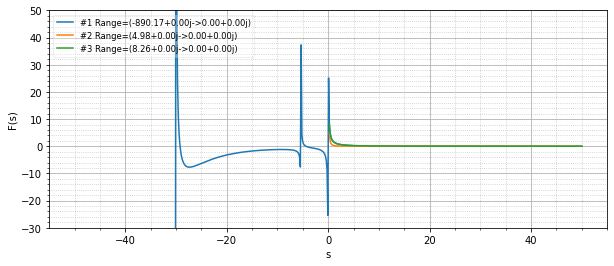

In [ ]:
#@title Compare Cohen laplace versions (either direct or forward transform of time)

importlib.reload(inverting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

VPEs = [
        (CohenModel(), fr"Cohen"), 
        #(getCohenModelModified(E1=3.5), fr"Cohen, $E_1=3.5$") 
        ]

plot_s = np.linspace(0.05, 2, num=1000, endpoint=True)
#plot_s = np.concatenate( [-plot_s, plot_s])
plot_s = np.linspace(-50+0j, 50+0j, num=666, endpoint=True)

t_new_anal = np.linspace(0.05, 100, num=1001, endpoint=True) 
min_s = 0.1

F_s_recalcs = [
               *[VPEs[ind][0].laplace_value(plot_s) for ind, _ in enumerate(VPEs) ],
               *[inverting.forward_laplace_transform(VPEs[ind][0].inverted_value, plot_s[plot_s>min_s], times=np.linspace(0, 100, num=1001, endpoint=True) ) for ind, _ in enumerate(VPEs)],
               *[inverting.forward_laplace_transform(inverting.euler_inversion(VPEs[ind][0].laplace_value, t_new_anal), plot_s[plot_s>min_s], times=t_new_anal ) for ind, _ in enumerate(VPEs) ],
               #*[laplace_vals_all[ind][0:len(plot_s)] for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_numerical_all[ind], plot_s, times=plot_times ) for ind, _ in enumerate(VPEs) ]
 
 ]

fig = plt.figure()
fig.set_figwidth(7.5)
fig.set_figwidth(10)
for ind, F_s_recalc in enumerate(F_s_recalcs):
    bounds = F_s_recalc[np.array([0,-1])]
    plt.plot(plot_s[-len(F_s_recalc):], F_s_recalc, label=f"#{ind+1} Range=({bounds[0]:5.2f}->{bounds[1]:5.2f})")
    print(bounds.round(2))
plt.xlabel("s")
plt.ylabel("F(s)")
plt.legend(framealpha=0.3, fontsize='small', loc="upper left")
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#plt.xlim([-0.5,None])
plt.ylim([-30, 50])

#F_s_recalcs
# (10.207851041127167*I0rts - 6.362394053190878*I1rts_s) / (I0rts - 0.2037125075633159*I1rts_s)
# (10.21*I0rts - 6.36*I1rts_s) / (I0rts - 0.204*I1rts_s)



In [ ]:
plot_s.shape
for ind, F_s_recalc in enumerate(F_s_recalcs):
    print(F_s_recalc.shape)

<IPython.core.display.Javascript object>

(666,)
(332,)
(666,)


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-pack

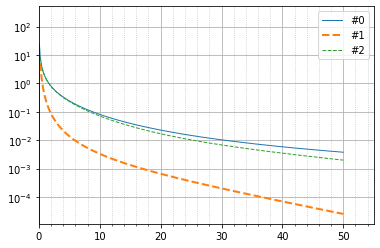

In [ ]:
#np.max( np.real_if_close(F_s_recalcs[1]) )
#np.nanargmax( np.real_if_close(F_s_recalcs[3]) ) #286
plt.figure()
for ind, F_s_recalc in enumerate(F_s_recalcs):
    plt.plot(plot_s[-len(F_s_recalc):], np.real_if_close(F_s_recalc),"-" if ind==0 else "--",lw=1 if ind==0 else len(F_s_recalcs)-ind, label=f"#{ind+1}")
    #plt.plot(plot_s[-len(F_s_recalcs[3]):], np.real_if_close(F_s_recalc),"--",lw=2)

plt.legend()

plt.xlim([0,None])

#plt.ylim([0,10])

plt.yscale('log')
#plt.ylim([None, np.nanmax(F_s_recalcs[3]) ] )
#plt.ylim([None, 1e100])

plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

#np.real_if_close(F_s_recalcs[1])[0]

#np.nanmax( np.real_if_close(F_s_recalcs[3][290:]) )

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


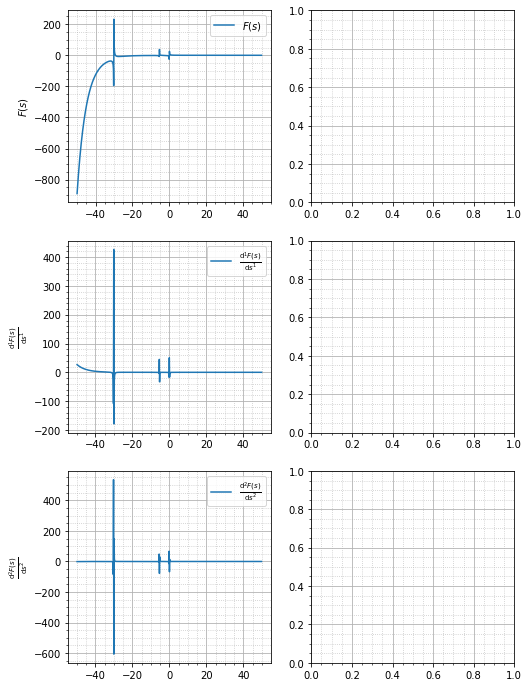

In [ ]:

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
#laplace_values_analytics = [ [VPEs[ind][0].laplace_value(plot_s) for ind, _ in enumerate(VPEs) ] ]
laplace_values_analytics = [VPEs[0][0].laplace_value(plot_s) ]
names = [r"F(s)"]
plot_ss = [ np.linspace(-50+0j, 50+0j, num=666, endpoint=True) ]
derivative_ct = 3
for ind in range(1,derivative_ct+1):
    laplace_values_analytics.append( np.diff(laplace_values_analytics[-1]) )
    plot_ss.append( (plot_ss[-1][0:-1]+plot_ss[-1][1:])/2 )
    names.append(r"\frac{\mathrm{d}^{"+str(ind)+"}"+names[0]+r"}{\mathrm{d}s^{"+str(ind)+"}}")


for ind, ax in enumerate(axs[:,0]):
    plot_s = plot_ss[ind]
    plot_s[abs(plot_s)<0.1 & abs(plot_s)<0.1 & abs(plot_s)<0.1]
    abs(plot_ss[ind])
    ax.plot(plot_ss[ind], laplace_values_analytics[ind], label=f"${names[ind]}$")
    ax.set_ylabel(f"${names[ind]}$")
    ax.legend()

for ax in axs.flat: 
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

plt.show()


## Bessel function plots

In [7]:
alpha=0.2
import scipy
res = scipy.optimize.fsolve(
                func=(lambda x: I0(x)-alpha*I1(x)/x) , x0=-10)
np.sqrt(res+0j)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([0.+0.02333606j])

In [17]:
ychange(yuneven_denom)

<IPython.core.display.Javascript object>

array([-2.47674674e-01, -2.47328815e-01, -2.46957609e-01, -2.46560992e-01,
       -2.46138904e-01, -2.45691283e-01, -2.45218073e-01, -2.44719217e-01,
       -2.44194663e-01, -2.43644359e-01, -2.43068258e-01, -2.42466313e-01,
       -2.41838480e-01, -2.41184717e-01, -2.40504986e-01, -2.39799249e-01,
       -2.39067473e-01, -2.38309625e-01, -2.37525677e-01, -2.36715601e-01,
       -2.35879373e-01, -2.35016971e-01, -2.34128377e-01, -2.33213573e-01,
       -2.32272547e-01, -2.31305286e-01, -2.30311782e-01, -2.29292029e-01,
       -2.28246024e-01, -2.27173766e-01, -2.26075258e-01, -2.24950506e-01,
       -2.23799516e-01, -2.22622300e-01, -2.21418872e-01, -2.20189247e-01,
       -2.18933447e-01, -2.17651491e-01, -2.16343407e-01, -2.15009223e-01,
       -2.13648969e-01, -2.12262681e-01, -2.10850394e-01, -2.09412151e-01,
       -2.07947994e-01, -2.06457970e-01, -2.04942129e-01, -2.03400524e-01,
       -2.01833211e-01, -2.00240248e-01, -1.98621700e-01, -1.96977630e-01,
       -1.95308109e-01, -

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2837: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


At s=-13.914+0.000j, output was -0.405 which plotted as -0.405


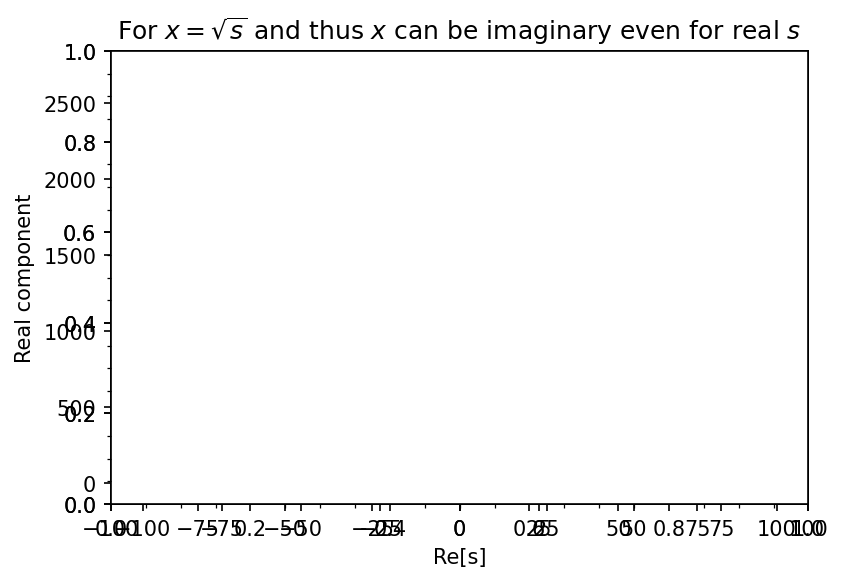

In [21]:
#@title Plot bessel functions (Cohen numerator) on real input
use_rt = True  #@param {type:"boolean"}
# 1 for real comp, 1j or -1 for imag comp, anything else for mag
plot_y_comp =  1 #@param [0,1,-1,"1j","np.inf", "np.pi", 10] {type:"raw"}
#scale_logp = False #@param {type:"boolean"}
alpha = 0.4 #@param {type:"slider", min:0, max:1, step:0.1}
imaginary_comp = 5.4  #@param {type:"slider", min:-10, max:10, step:0.1}
t_pt_val = 1

 

if use_rt:
    s=np.linspace(start=-100, stop=100, num=1000, endpoint=True)+0j
else:
    s=np.linspace(start=-10, stop=10, num=1000, endpoint=True)+0j


fig = plt.figure(dpi=150)
ax=fig.add_subplot(1, 1, 1)
if use_rt:
    ax.set_title(r"For $x=\sqrt{s}$ and thus $x$ can be imaginary even for real $s$")
else:
    ax.set_title(r"For $x=s$")

if use_rt:
    x = np.sqrt(s+0j)
else:
    x = s + 0j
yuneven_denom = I0(x)-alpha*I1(x)/x
#plt.plot(s, ychange(x), label=r"$x$")
#for v in [0,]:
#    plt.plot(s, ychange(Iv(x,v=v)), label=f"$I_{v}(x)$")
#plt.plot(s, ychange(I1(x)/x), label=r"$\frac{I_1(x)}{x}$")
#plt.plot(s, ychange(I0(x)-I1(x)),"--", label=r"$I_{0}(x)-I_{1}(x)$")
#plt.plot(s, ychange(I0(x)-I1(x)/x),"--", label=r"$I_{0}(x)-\frac{I_1(x)}{x}$")
denom_label = f"I_0(x)-{alpha:.1f}"+r"\frac{I_1(x)}{x}"
ax.plot(s, ychange(yuneven_denom),"--", label=f"${denom_label}$")
argminind = np.argmin(yuneven_denom)
print(f"At s={s[argminind]:.3f}, output was {np.real_if_close(yuneven_denom[argminind]):.3f} which plotted as {ychange(yuneven_denom[argminind]):.3f}" )
ax.plot(s[argminind], ychange(yuneven_denom[argminind]),"o")

#plt.plot(s, ychange(yuneven_numer/yuneven_denom * np.exp(s*t_pt_val)), label=r"$(I_0(x)-\alpha\frac{I_1(x)}{x})e^{st}$")


ax.set_xlabel("Re[s]")

ax.legend()
ax.grid(which="major")  # set major grid lines
ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.xlim([np.min(s),np.max(s)])
if False:  #scale_logp: #np.median(np.abs((ychange(x)-x)/x)) > 0.1
    ax.set_ylabel("$ln(1+|y|)$, " + ychange(0, return_name=True))
    #plt.ylabel("$ln(1+|y|)$, " + ("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    ax.set_ylim([-5,10])
else:
    #plt.ylabel(("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    ax.set_ylabel(ychange(0, return_name=True))
    #plt.ylim([-500,1000])
    #ax.set_ylim([-5,10])

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipyker

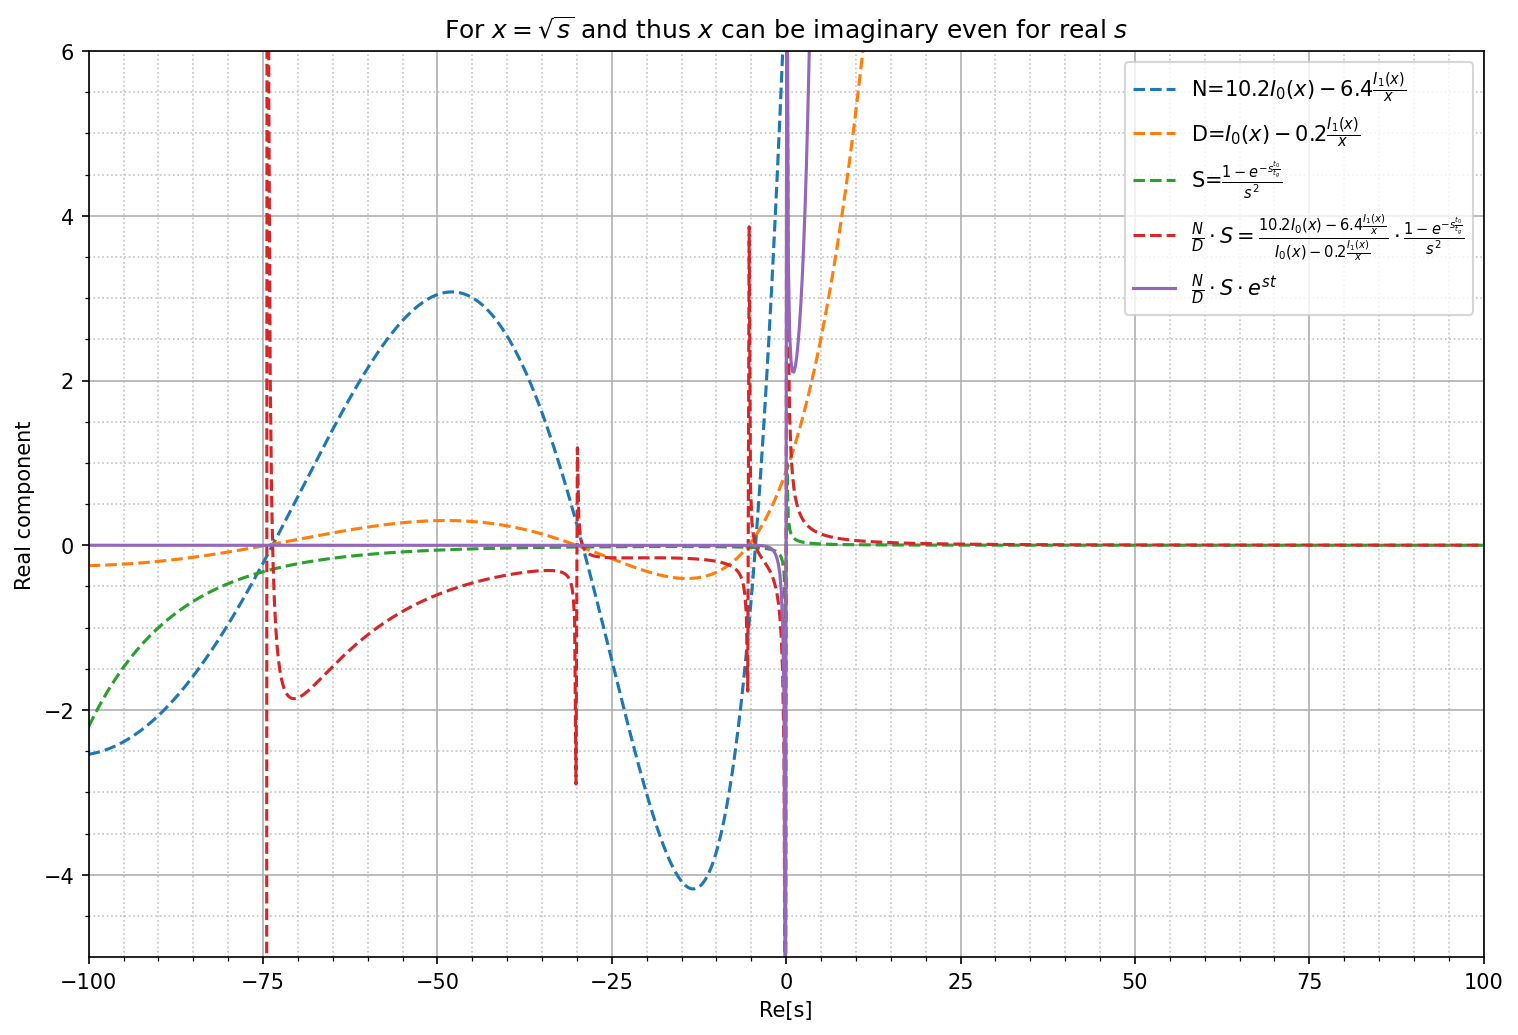

In [ ]:
#@title Cohen components plot on real input
use_rt = True  #@param {type:"boolean"}
# 1 for real comp, 1j or -1 for imag comp, anything else for mag
plot_y_comp =  1 #@param [0,1,-1,"1j","np.inf", "np.pi", 10] {type:"raw"}
#scale_logp = False #@param {type:"boolean"}
alpha = 0.203713 #@param {type:"slider", min:0, max:1, step:0.1}
imaginary_comp = 5.4  #@param {type:"slider", min:-10, max:10, step:0.1}
t_pt_val = 1

C0=0.203713  # alpha
C1=10.207851
C2=31.232221
t0_tg=0.1


if use_rt:
    s=np.linspace(start=-100, stop=100, num=1000, endpoint=True)+0j
else:
    s=np.linspace(start=-10, stop=10, num=1000, endpoint=True)+0j


fig = plt.figure(figsize=(12,8))
fig.set_dpi(150)

if use_rt:
    plt.title(r"For $x=\sqrt{s}$ and thus $x$ can be imaginary even for real $s$")
else:
    plt.title(r"For $x=s$")

if use_rt:
    x = np.sqrt(s+0j)
else:
    x = s + 0j
#plt.plot(s, ychange(x), label=r"$x$")
#for v in [0,]:
#    plt.plot(s, ychange(Iv(x,v=v)), label=f"$I_{v}(x)$")
#plt.plot(s, ychange(I1(x)/x), label=r"$\frac{I_1(x)}{x}$")
#plt.plot(s, ychange(I0(x)-I1(x)),"--", label=r"$I_{0}(x)-I_{1}(x)$")
#plt.plot(s, ychange(I0(x)-I1(x)/x),"--", label=r"$I_{0}(x)-\frac{I_1(x)}{x}$")

yuneven_numer = C1*I0(x)-C0*C2*I1(x)/x
yuneven_denom = I0(x)-alpha*I1(x)/x
numer_label = f"{C1:.1f}I_0(x)-{C0*C2:.1f}"+r"\frac{I_1(x)}{x}"
denom_label = f"I_0(x)-{alpha:.1f}"+r"\frac{I_1(x)}{x}"
strain_s=(1-np.exp(-t0_tg*s))/(s*s)
strain_s_label = r"\frac{1-e^{-s\frac{t_0}{t_g}}}{s^2}"
plt.plot(s, ychange(yuneven_numer),"--", label=f"N=${numer_label}$")
plt.plot(s, ychange(yuneven_denom),"--", label=f"D=${denom_label}$")

plt.plot(s, ychange(strain_s),"--", label=f"S=${strain_s_label}$")
plt.plot(s, ychange(yuneven_numer/yuneven_denom*strain_s),"--", label=r"$\frac{N}{D}\cdot S=\frac{"+numer_label+r"}{"+denom_label+r"}\cdot"+strain_s_label+"$")

plt.plot(s, ychange(yuneven_numer/yuneven_denom*strain_s * np.exp(s*t_pt_val)), label=r"$\frac{N}{D}\cdot S \cdot e^{st}$")


plt.xlabel("Re[s]")

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.xlim([np.min(s),np.max(s)])
if False:  #scale_logp: #np.median(np.abs((ychange(x)-x)/x)) > 0.1
    plt.ylabel("$ln(1+|y|)$, " + ychange(0, return_name=True))
    #plt.ylabel("$ln(1+|y|)$, " + ("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylim([-5,6])
else:
    #plt.ylabel(("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylabel(ychange(0, return_name=True))
    #plt.ylim([-500,1000])
    plt.ylim([-5,6])



# Imaginary input plots

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


0.731245795100594


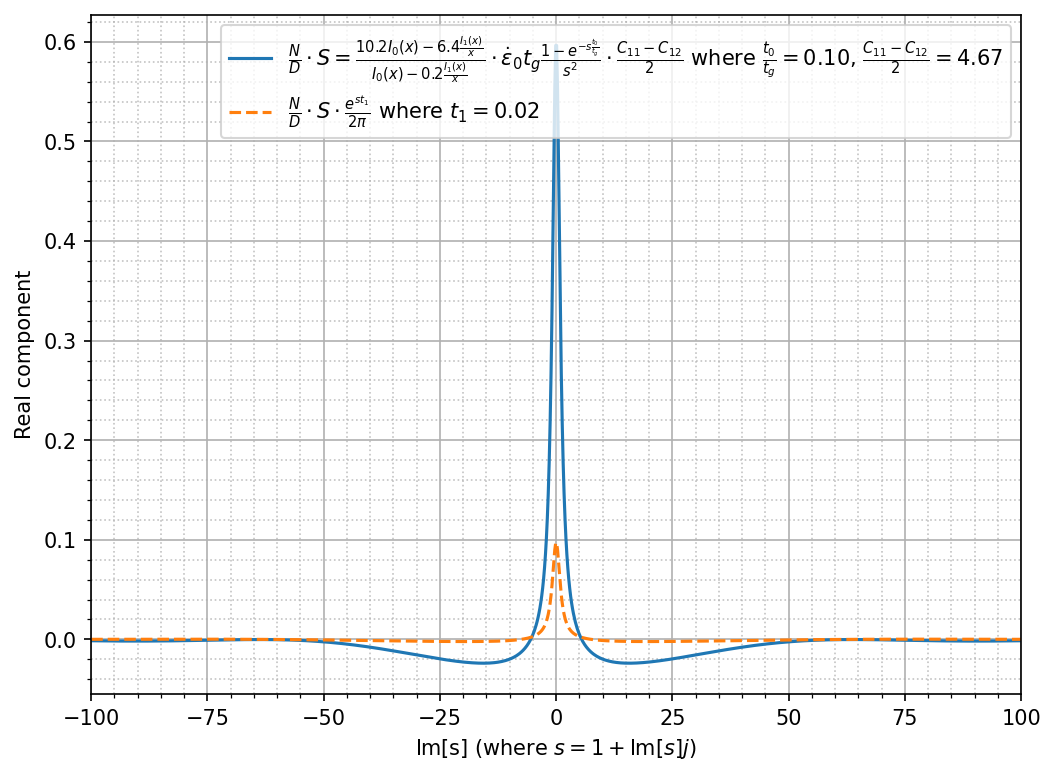

In [ ]:
#@title Cohen components plot on imaginary input

use_rt = True  #@param {type:"boolean"}
# 1 for real comp, 1j or -1 for imag comp, anything else for mag
plot_y_comp =  1 #@param [0,1,-1,"1j","np.inf", "np.pi", 10] {type:"raw"}
#scale_logp = False #@param {type:"boolean"}
alpha = 0.203713 #@param {type:"slider", min:0, max:1, step:0.1}
imaginary_comp = 5.4  #@param {type:"slider", min:-10, max:10, step:0.1}
t_pt_val = 0.02  #@param {type:"slider", min:-10, max:10, step:0.1}
t1 = np.array([t_pt_val])
#t1 = np.array([.05, 0.246184, 0.5])


s_real = 1 #@param {type:"slider", min:-10, max:10, step:0.1}

C11 = 5.494505
C12 = 1.648352
C0=0.203713  # alpha
C1=10.207851
C2=31.232221
t0_tg=0.1
tg=40.62
strain_rate = 0.01 

if use_rt:
    s=s_real+1j*np.linspace(start=-100, stop=100, num=1000, endpoint=True)
    x = np.sqrt(s+0j)
else:
    s=s_real+1j*np.linspace(start=-10, stop=10, num=1000, endpoint=True)
    x = s + 0j


yuneven_numer = C1*I0(x)-C0*C2*I1(x)/x
yuneven_denom = I0(x)-alpha*I1(x)/x
numer_label = f"{C1:.1f}I_0(x)-{C0*C2:.1f}"+r"\frac{I_1(x)}{x}"
denom_label = f"I_0(x)-{alpha:.1f}"+r"\frac{I_1(x)}{x}"
strain_s=strain_rate * tg*(1-np.exp(-t0_tg*s))/(s*s)*(C11-C12)/2
strain_s_label = r"\dot{\epsilon}_0 t_g \frac{1-e^{-s\frac{t_0}{t_g}}}{s^2} \cdot \frac{C_{11}-C_{12}}{2}$ where $\frac{t_0}{t_g}=" \
                 + f"{t0_tg:.2f}$, $" + r"\frac{C_{11}-C_{12}}{2}="  \
                 + f"{(C11-C12/2):.2f}"  # don't end with $, that is added later

SN_D = yuneven_numer/yuneven_denom*strain_s

fig = plt.figure(figsize=(8,6))
fig.set_dpi(150)

#plt.plot(np.imag(s), ychange(yuneven_numer),"-", label=f"N=${numer_label}$")
#plt.plot(np.imag(s), ychange(yuneven_denom),"-", label=f"D=${denom_label}$")
#plt.plot(np.imag(s), ychange(strain_s),"-", label=f"S=${strain_s_label}$")
plt.plot(np.imag(s), ychange(SN_D),"-", 
         label=r"$\frac{N}{D}\cdot S=\frac{"+numer_label+r"}{"+denom_label+r"}\cdot"+strain_s_label+"$")


for t1_val in t1:
    #plt.plot(np.imag(s), ychange(SN_D * np.exp(s*t1_val)), 
    #         label=r"$\frac{N}{D}\cdot S \cdot e^{st_1}$ where $"+f"t_1={t1_val:.2f}$")
    inverse_laplace_applied = SN_D * np.exp(s*t1_val)/(2*np.pi)
    plt.plot(np.imag(s), ychange( inverse_laplace_applied ), "--", 
            label=r"$\frac{N}{D}\cdot S \cdot \frac{e^{st_1}}{2\pi}$ where $"+f"t_1={t1_val:.2f}$")


plt.xlabel(r"$\mathrm{Im\left[s\right]}$ (where $s="+f"{s_real}"+r"+\mathrm{Im}\left[s\right]j$)")

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.xlim([np.min(np.imag(s)),np.max(np.imag(s))])
#plt.ylim([np.min(SN_D)*1.5, np.max(SN_D)*1.5])
if False:  #scale_logp: #np.median(np.abs((ychange(x)-x)/x)) > 0.1
    plt.ylabel("$ln(1+|y|)$, " + ychange(0, return_name=True))
    #plt.ylabel("$ln(1+|y|)$, " + ("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylim([-5,6])
else:
    #plt.ylabel(("Imag" if plot_y_comp in [1j,-1,-1j] else "Real") + " component" )
    plt.ylabel(ychange(0, return_name=True))
    #plt.ylim([-500,1000])
    #plt.ylim([-0.5,0.5])


print(np.real_if_close(np.sum(inverse_laplace_applied)))



## Expanding the exponential term
$s=\left(\Re\left[s\right]+i\Im\left[s\right] \right)=a+bi$  
Recall $\sqrt{i}=\frac{1+i}{\sqrt{2}}$ and  $1/i=-i$

\begin{align}
\operatorname{e}^{st_1}
 &= \operatorname{e}^{\left(a+bi\right)t_1}
 = \operatorname{e}^{at_1}\cdot\operatorname{e}^{bi \cdot t_1}
 = \operatorname{e}^{at_1} \left( \cos{bt_1} + i\sin{bt_1}  \right) \\
 &= \color{red}{\operatorname{e}^{at_1} \cos{bt_1}} + i \color{blue}{\operatorname{e}^{at_1} \sin{bt_1}} \\
 &= \color{red}{\operatorname{e}^{t_1\Re[s]} \cos{\left(t_1\Im[s]\right)}} + i \color{blue}{\operatorname{e}^{t_1\Re[s]} \sin{\left(t_1\Im[s]\right)}}
\end{align}

\begin{align}
&\Re\left[\operatorname{e}^{st_1}\right]=\color{red}{\operatorname{e}^{at_1} \cos{bt_1}},
&\Im\left[\operatorname{e}^{st_1}\right]=\color{blue}{\operatorname{e}^{at_1} \sin{bt_1}}
\end{align}

\\
\\
\begin{align}
\frac{\operatorname{e}^{st_1}}{2\pi i}
 &= \frac{\operatorname{e}^{at_1}}{2\pi} \left( -i\cos{bt_1} + \sin{bt_1} \right) \\
 &= \color{red}{\frac{\operatorname{e}^{at_1}}{2\pi} \sin{bt_1}}+i\color{blue}{\left(-\frac{\operatorname{e}^{at_1}}{2\pi} \cos{bt_1} \right)} \\
 &= \color{red}{\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \sin{\left( t_1 \Im[s] \right)}}+i\color{blue}{\left(-\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \cos{\left( t_1 \Im[s] \right)} \right) }
 \end{align}

\begin{align}
&\Re\left[\frac{\operatorname{e}^{st_1}}{2\pi i}\right]=\color{red}{\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \sin{\left( t_1 \Im[s] \right)}}, 
&\Im\left[\frac{\operatorname{e}^{st_1}}{2\pi i}\right]=\color{blue}{-\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \cos{\left( t_1 \Im[s] \right)}}
\end{align}

\\ 
\\ 





\begin{align} 
\frac{1-\exp{\left(-s\frac{t_0}{t_g}\right)}}{s^2}
&=\frac{1-\exp{\left(-\frac{t_0}{t_g}s\right)}}{a^2+b^2} 
= \frac{1-\left( \operatorname{e}^{-\frac{t_0}{t_g}a} \cos{\left(-\frac{t_0}{t_g}b\right)} + i \operatorname{e}^{-\frac{t_0}{t_g}a} \sin{\left(-\frac{t_0}{t_g}b\right)} \right)}{a^2+b^2} \\
&= \frac{1- \operatorname{e}^{-\frac{t_0}{t_g}a} \cos{\left(-\frac{t_0}{t_g}b\right)} + i \left( -\operatorname{e}^{-\frac{t_0}{t_g}a} \sin{\left(-\frac{t_0}{t_g}b\right)} \right) }{a^2+b^2} \\
&= \color{red}{\frac{1- \operatorname{e}^{-\frac{t_0}{t_g}a}}{a^2+b^2} \cos{\left(-\frac{t_0}{t_g}b\right)}}  + i \color{blue}{\frac{ -\operatorname{e}^{-\frac{t_0}{t_g}a}}{a^2+b^2} \sin{\left(-\frac{t_0}{t_g}b\right)}}   \\
&= \color{red}{\frac{1- \operatorname{e}^{-\frac{t_0}{t_g}\Re[s]}}{\Re[s]^2+\Im[s]^2} \cos{\left(-\frac{t_0}{t_g}\Im[s]\right)}}  + i \color{blue}{\frac{ -\operatorname{e}^{-\frac{t_0}{t_g}\Re[s]}}{\Re[s]^2+\Im[s]^2} \sin{\left(-\frac{t_0}{t_g}\Im[s]\right)}}   \\
\end{align}


## Inverse Laplace Equations in Latex
$$f(t=\frac{t_0}{t_g})=\frac{1}{2\pi i} \int_{c-i \infty}^{c+i \infty} F(s)\mathrm{e}^{s\frac{t_0}{t_g}} \mathrm{d}s$$  

$$F(s)= \dot{\epsilon}_0 t_g \left( \frac{C_{11}-C_{12}}{2}\right) \left(  \frac{ 1-\mathrm{e}^{-s\frac{t_0}{t_g}} }{s^2} \right) \left( \frac{ C_1 I_0(\sqrt{s})-C_2 C_0 \frac{I_1(\sqrt{s}) }{\sqrt{s}} }{ I_0(\sqrt{s})-C_0\frac{I_1(\sqrt{s})}{\sqrt{s}} } \right) $$



\begin{align}
s&=a+bi=\Re{[s]}+i\Im{[s]} \\
\mathrm{d}s&=\mathrm{d}a+i \mathrm{d}b = \mathrm{d}a + i \mathrm{d}\Im{[s]}
\end{align}

\\
\begin{align}
f(t=\frac{t_0}{t_g})&=\frac{1}{2\pi i} \int_{a-i \infty}^{a+i \infty} F(s)\mathrm{e}^{s\frac{t_0}{t_g}} \mathrm{d}s \\
&=\int_{a-i \infty}^{a+i \infty} F(s)\frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \mathrm{d}s \\
&=\int_{a-i \infty}^{a+i \infty} \left(\Re{\left[F(s)\right]}+i\Im{\left[F(s)\right]}\right) \left(\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} + i\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \right) \mathrm{d}i\Im{[s]}  \\
&=\int_{a-i \infty}^{a+i \infty} \left(\Re{\left[F(s)\right]}+i\Im{\left[F(s)\right]}\right) \left(\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} + i\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \right) \!i \; \mathrm{d}\Im{[s]}  \\
&=\int_{a-i \infty}^{a+i \infty}\left(
    \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
    +i\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} 
    +i\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \\
    +i^2\Im{\left[F(s)\right]}\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
    \right) \!i \; \mathrm{d}\Im{[s]} \\
&=\int_{s=a-i \infty}^{s=a+i \infty}
    i^2 \left( 
        \Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
        +\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} 
    \right) \\
    &+i \left( 
        \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
        +i^2\Im{\left[F(s)\right]}\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} 
    \right)
    \; \mathrm{d}\Im{[s]} \\
&=\int_{s=a-i \infty}^{s=a+i \infty}
    -\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
    -\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \\
    &+i \left( 
        \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}
        -\Im{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} 
    \right)
    \; \mathrm{d}\Im{[s]} \\
&=\color{red}{\int_{s=a-i \infty}^{s=a+i \infty} -\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}-\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}  \mathrm{d}\Im{[s]}}\\ 
&+i \color{blue}{\int_{s=a-i \infty}^{s=a+i \infty} \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} -\Im{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \mathrm{d}\Im{[s]}} \\
\end{align}


## Simplify
$$
\begin{align}
&\Re\left[\frac{\operatorname{e}^{st_1}}{2\pi i}\right]=\color{red}{\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \sin{\left( t_1 \Im[s] \right)}}, 
&\Im\left[\frac{\operatorname{e}^{st_1}}{2\pi i}\right]=\color{blue}{-\frac{\operatorname{e}^{t_1\Re[s]}}{2\pi} \cos{\left( t_1 \Im[s] \right)}}
\end{align}
\\

\begin{align}
\Re{\left[f(t=\frac{t_0}{t_g})\right]}&=\color{red}{\int_{s=a-i \infty}^{s=a+i \infty} -\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \quad -\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \quad \mathrm{d}\Im{[s]}}
\\ 
&=\color{red}{\int_{s=a-i \infty}^{s=a+i \infty} -\Re{\left[F(s)\right]}\cdot -\frac{\operatorname{e}^{t_0/t_g\Re[s]}}{2\pi} \cos{\left( t_0/t_g \Im[s] \right)} \quad -\Im{\left[F(s)\right]}\cdot \frac{\operatorname{e}^{t_0/t_g\Re[s]}}{2\pi} \sin{\left( t_0/t_g \Im[s] \right)} \quad  \mathrm{d}\Im{[s]}}\\
&=\color{red}{\int_{s=a-i \infty}^{s=a+i \infty} \Re{\left[F(s)\right]} \frac{\operatorname{e}^{at_0/t_g}}{2\pi} \cos{\left( t_0/t_g \Im[s] \right)} \quad -\Im{\left[F(s)\right]} \frac{\operatorname{e}^{a t_0/t_g}}{2\pi} \sin{\left( t_0/t_g \Im[s] \right)} \quad  \mathrm{d}\Im{[s]}}\\ 
&=\color{red}{\int_{b=-\infty}^{b=\infty} \Re{\left[F(a+bi)\right]} \frac{\operatorname{e}^{at_0/t_g}}{2\pi} \cos{\left( t_0/t_g b \right)} \quad -\Im{\left[F(a+bi)\right]} \frac{\operatorname{e}^{a t_0/t_g}}{2\pi} \sin{\left( t_0/t_g b \right)} \quad  \mathrm{d} b}\\ 
&= \frac{\operatorname{e}^{a\frac{t_0}{t_g}}}{2\pi} \int_{-\infty}^{\infty} \Re{\left[F(a+bi)\right]}  \cos{\left(\frac{t_0}{t_g} b \right)} \quad -\Im{\left[F(a+bi)\right]}  \sin{\left( \frac{t_0}{t_g} b \right)} \quad  \mathrm{d} b\\ 
\\
\\
\Im{\left[f(t=\frac{t_0}{t_g})\right]}&= \color{blue}{\int_{s=a-i \infty}^{s=a+i \infty} \quad \Re{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \quad -\Im{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]} \quad \mathrm{d}\Im{[s]}} \\
&= \frac{\operatorname{e}^{a\frac{t_0}{t_g}}}{2\pi} \int_{-\infty}^{\infty} \Re{\left[F(a+bi)\right]} \sin{\left(\frac{t_0}{t_g} b \right)} \quad + \Im{\left[F(a+bi)\right]}  \cos{\left( \frac{t_0}{t_g} b \right)} \quad  \mathrm{d} b\\ 
\end{align}



\\
\\
\begin{align}
\Re{\left[f(t=\frac{t_0}{t_g})\right]}&=\int_{s=a-i \infty}^{s=a+i \infty}& -&\Re{\left[F(s)\right]}\cdot\Im{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}&-\Im{\left[F(s)\right]}\cdot\Re{\left[ \frac{\exp{\left(s\frac{t_0}{t_g}\right)}}{2\pi i} \right]}  &\mathrm{d}\Im{[s]}\\
&= \frac{\operatorname{e}^{a\frac{t_0}{t_g}}}{2\pi}  \int_{-\infty}^{\infty}& &\Re{\left[F(a+bi)\right]}  \cos{\left(\frac{t_0}{t_g} b \right)} \quad &-\Im{\left[F(a+bi)\right]}  \sin{\left( \frac{t_0}{t_g} b \right)} \quad  &\mathrm{d} b\\
\Im{\left[f(t=\frac{t_0}{t_g})\right]}&= \frac{\operatorname{e}^{a\frac{t_0}{t_g}}}{2\pi} \int_{-\infty}^{\infty}& &\Re{\left[F(a+bi)\right]} \sin{\left(\frac{t_0}{t_g} b \right)} \quad &+ \Im{\left[F(a+bi)\right]}  \cos{\left( \frac{t_0}{t_g} b \right)} \quad  &\mathrm{d} b\\
\end{align}

**Integration by parts formula:**
$$ 
\begin{align}
\int u \; \d v &= uv - \int v \; \d u  \\
\int u(x) \left(\! \dd{v}{x} \!\right) \d x  &= u(x)v(x) - \int v \left(\! \dd{u}{x} \!\right) \d x   \\
\int_a^b u(x) \left(\!\dd{v}{x}\!\right) \d x &= \big[ u(x)v(x) \big]^b_a - \int_a^b v(x) \left(\! \dd{u}{x} \!\right) \d x  \\
\end{align}
$$




\begin{alignat}{4}
\Re{\left[f(t=\frac{t_0}{t_g})\right]}
&&= \frac{\operatorname{e}^{a\frac{t_0}{t_g}}}{2\pi}  \int_{-\infty}^{\infty}&&\Re{\left[F(a+bi)\right]}  \cos{\left(\frac{t_0}{t_g} b \right)} &&-\Im{\left[F(a+bi)\right]}  \sin{\left( \frac{t_0}{t_g} b \right)} \;  && \mathrm{d} b\\
\Im{\left[f(t=\frac{t_0}{t_g})\right]}&&= \frac{\operatorname{e}^{a\frac{t_0}{t_g}}}{2\pi} \int_{-\infty}^{\infty}&&\Re{\left[F(a+bi)\right]} \sin{\left(\frac{t_0}{t_g} b \right)} &&+ \Im{\left[F(a+bi)\right]}  \cos{\left( \frac{t_0}{t_g} b \right)} \;  &&\mathrm{d} b\\
\end{alignat}

\begin{alignat}{4}
\int_{-\infty}^{\infty}&& \Im{\left[F(a+bi)\right]}  \sin{\left( \frac{t_0}{t_g} b \right)} \;  && \mathrm{d} b\\
\end{alignat}

\begin{gather}
u(b)=\Re{\left[F(a+bi)\right]}  &\xrightarrow{}&  
\partial{u} \stackrel{?}{=} \Re{\left[\ddp{F(a+bi)}{b} \partial{b} \cdot i \right]} \\
&&= i\Re{\left[F'(a+bi) \right]} \partial{b}  
\\ v(b)= \frac{t_g}{t_0} \sin{\left( \frac{t_0}{t_g} b \right)}  &\xrightarrow{}& 
\partial{v}= \cos{\left( \frac{t_0}{t_g} b \right)} \partial{b}
\end{gather}

$$
\begin{align} 
\int_{-\infty}^{\infty} \Re{\left[F(a+bi)\right]}  \cos{\left(\frac{t_0}{t_g} b \right)} \, \d{b} &= \begin{split} \left.
\Re{\left[F(a+bi)\right]} \frac{t_g}{t_0} \sin{\left( \frac{t_0}{t_g} b \right)}\right|_{-\infty}^{\infty}- \int_{-\infty}^{\infty} \frac{t_g}{t_0} \sin{\left( \frac{t_0}{t_g} b \right)} \Re{\left[F'(a+bi)  \right]} \, \d{b} 
\end{split}  \\
&= 0- \int_{-\infty}^{\infty} \frac{t_g}{t_0} \sin{\left( \frac{t_0}{t_g} b \right)} i \Re{\left[F'(a+bi)  \right]} \, \d{b}  \\
&= 0-0 + \int_{-\infty}^{\infty} -\left(\frac{t_g}{t_0}\right)^2 \cos{\left( \frac{t_0}{t_g} b \right)} i^2 \Re{\left[F''(a+bi)  \right]} \, \d{b} 
= \int_{-\infty}^{\infty} \left(\frac{t_g}{t_0}\right)^2 \cos{\left( \frac{t_0}{t_g} b \right)} \Re{\left[F''(a+bi)  \right]} \, \d{b} 
\end{align}
$$

---



* Confirm numerically that $\Re[F(s)]$ goes towards $0$ as $b$ goes towards $\pm\infty$ where $s=a+bi$ and $a$ is constant.  
Alternatively $$\lim_{b\to\pm\infty}\Re{\left[F(a+bi)\right]}\stackrel{?}{=}0$$
* This makes sense given that $\frac{1}{s^2}$ is one of the components of the strain portion of $F(s)$.    
* I believe this implies that all derivatives are 0 i.e. $\Re\dd[(m)]{F(s)}{s}\stackrel{?}{=}0$ for $m \in \mathbb{N}$ (where $\mathbb{N}$ is the set of natural numbers i.e. $1,2,3,\dots$)

In [155]:
b_start, b_stop, b_freq = 0, 6, 0.5
a=100
b=np.logspace(start=b_start,stop=b_stop,num=int((b_stop-b_start)*b_freq+1+0.5), endpoint=True)
vpe=CohenModel()

"""pd.DataFrame( {"b": b,
               "F(a-bj)":[vpe.laplace_value(a-b*1j).real,vpe.laplace_value(a-b*1j).imag],
               "F(a+bj)":vpe.laplace_value(a+b*1j).real
},index=[f"10^{np.log10(b_val):0.2f}" for b_val in b])"""
# ,index=[f"10^{np.log10(b_val):0.2f}" for b_val in b]

df=pd.DataFrame({
    ("s","a"): np.full_like(b,a),
    ("s","b"): b,
    ("F(a-bj)","Re"):vpe.laplace_value(a-b*1j).real,
    ("F(a-bj)","Im"):vpe.laplace_value(a-b*1j).imag,
    ("F(a+bj)","Re"):vpe.laplace_value(a+b*1j).real,
    ("F(a+bj)","Im"):vpe.laplace_value(a+b*1j).imag,
    },index=[f"10^{np.log10(b_val):.1f}" for b_val in b])
df.columns= pd.MultiIndex.from_tuples(df.columns)
df


<IPython.core.display.Javascript object>

/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1274: RuntimeWarning: invalid value encountered in true_divide
  I1rts_s = I1(sqrt(s)) / sqrt(s)
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1278: RuntimeWarning: invalid value encountered in multiply
  F = (C1*I0rts - C2*C0*I1rts_s) / (I0rts - C0*I1rts_s) * eps_zz
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1278: RuntimeWarning: invalid value encountered in true_divide
  F = (C1*I0rts - C2*C0*I1rts_s) / (I0rts - C0*I1rts_s) * eps_zz


s             ...       F(a+bj)              
            a          b  ...            Re            Im
10^0.0  100.0        1.0  ...  9.658370e-04 -1.912193e-05
10^2.0  100.0      100.0  ...  6.449655e-06 -4.874097e-04
10^4.0  100.0    10000.0  ... -1.003627e-07 -2.303475e-09
10^6.0  100.0  1000000.0  ...           NaN           NaN

[4 rows x 6 columns]

# Numerically invert at each step

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:153: RuntimeWarning: divide by zero encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:153: RuntimeWarning: invalid value encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spec

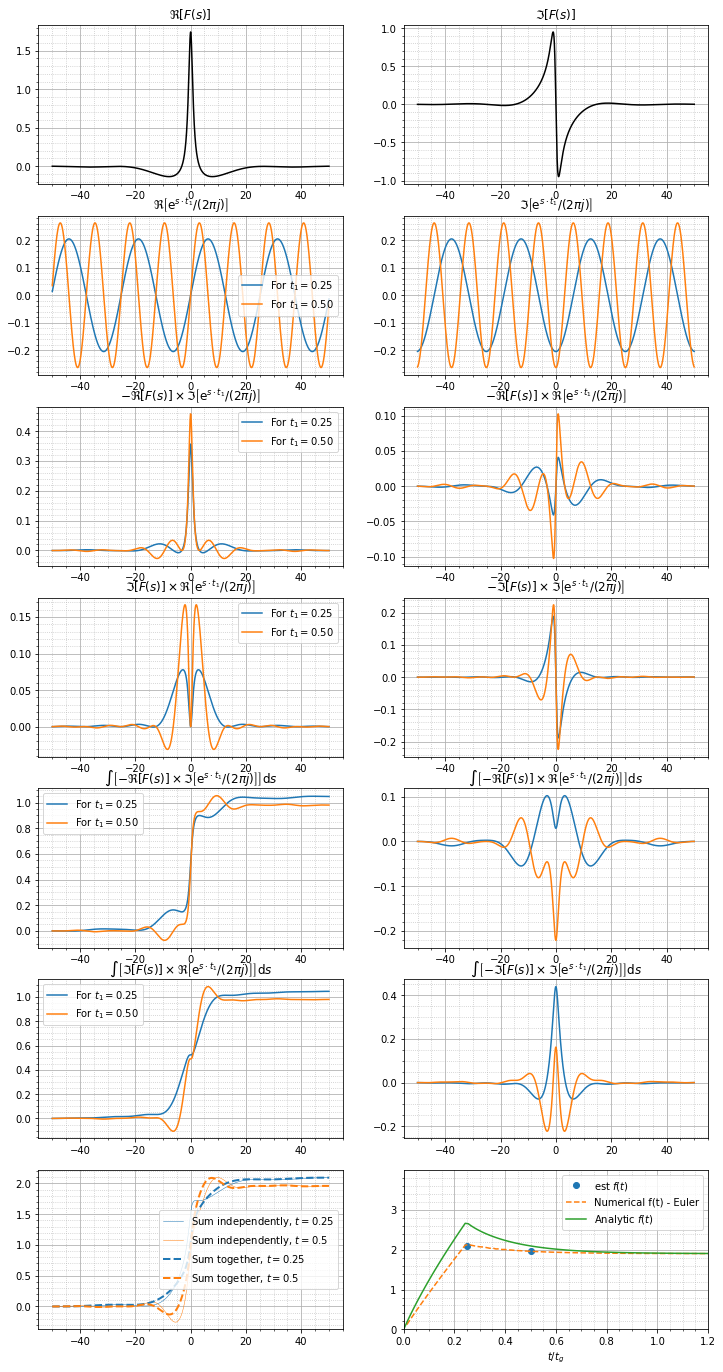

In [ ]:
#@title Steps of inverse laplace of Cohen

s_real = 1 #@param {type:"slider", min:-10, max:10, step:0.1}
(s, ds)=np.linspace(start=s_real-50j, stop=s_real+50j, num=10000, endpoint=True, retstep=True)
#t1 = np.array([.05, 0.246184, 0.5])
t1 = np.array([0.25, 0.5])

VPEs = [
        (CohenModel(), fr"$Cohen$"), 
        #(getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") 
        ]
vpe = VPEs[0][0]
# The [...,None] index allows t1 to be either a single value (returns single value) or a matrix (returns matrix)
laplace_val = vpe.laplace_value(s, dimensional=True)
expon_2pii = np.exp(s[...,None]*t1)/(2j*np.pi)
ys = [
        (laplace_val, "F(s)"), 
        (expon_2pii, r"\mathrm{e}^{s \cdot t_1}/(2 \pi j)")
        ]
ys2 = [[(y.real, fr"\Re\left[ {name} \right]"), (y.imag, fr"\Im\left[ {name} \right]")] for y,name in ys]
ys2.append([ 
            (-(ys[0][0].real*ys[1][0].imag.T).T, fr"-\Re\left[ {ys[0][1]} \right]\times\Im\left[ {ys[1][1]} \right]"), 
            ((ys[0][0].real*ys[1][0].real.T).T, fr"-\Re\left[ {ys[0][1]} \right]\times\Re\left[ {ys[1][1]} \right]") 
            ] )
ys2.append([  # Decide whether to use negative or positive based on the underlying equations
            (-(ys[0][0].imag*ys[1][0].real.T).T, fr"\Im\left[ {ys[0][1]} \right]\times\Re\left[ {ys[1][1]} \right]"), 
            (-(ys[0][0].imag*ys[1][0].imag.T).T, fr"-\Im\left[ {ys[0][1]} \right]\times\Im\left[ {ys[1][1]} \right]") 
            ] )
for ind1, ys2row in enumerate(ys2[-2:]):
    ys2.append([])
    for ind2, (y, name) in enumerate(ys2row):
        ys2[-1].append( (np.cumsum(y, axis=0)*ds.imag, r"\int \left[ "+name+r" \right] \mathrm{d}s") )



fig10, axs = plt.subplots(nrows=len(ys2)+1, ncols=2, figsize=(12,24))
#fig10 = plt.figure(constrained_layout=True, figsize=(16,20))

"""gs0 = fig10.add_gridspec(nrows=3, ncols=1)
gs00 = gs0[0].subgridspec(2,2)
gs01 = gs0[1].subgridspec(2,4)
axs = plt.subplots()
axs = []
for ind, y in enumerate(ys):
    axs.append( fig10.add_subplot(gs00[ind,0]) )
    axs.append( fig10.add_subplot(gs00[ind,1]) )
"""

#axs = fig10.get_axes()
for ind, ys2row in enumerate(ys2):
    for ind2, (y2, name) in enumerate(ys2row):
        ax=axs.flat[ind*2+ind2]
        ax.plot(np.imag(s), np.real(y2), "k" if y2.ndim<=1 else "")
        ax.set_title(f"${name}$")
        if y2.ndim>1 and ind2==0:
            ax.legend([f"For $t_1={t1_val:.2f}$" for t1_val in t1 ])
        
summation = 0
for ind in range(2):
    summation += ys2[-1][ind][0]+ys2[-2][ind][0]
axs[-1,0].plot(s.imag, summation, "-", linewidth=0.5)
axs[-1,0].set_prop_cycle(None)  # Resets the color cycle so colors of lines match the colors of plot
axs[-1,0].plot(s.imag, (np.cumsum(laplace_val * expon_2pii.T, axis=-1)*ds).T, "--", linewidth=2)
axs[-1,0].legend(
    [f"Sum independently, $t={t1_val}$" for t1_val in t1]+
    [f"Sum together, $t={t1_val}$" for t1_val in t1]
    )

t_plot = np.linspace(0,1.2,num=100,endpoint=True)
analytic_values_plot = vpe.inverted_value(t=t_plot*vpe.tg)

axbig=axs[-1,1]
axbig.plot(t1, summation[-1,:],"o", label="est $f(t)$")
axbig.plot(t_plot, inverting.euler_inversion(vpe.laplace_value, t_plot), "--", label="Numerical f(t) - Euler")
axbig.plot(t_plot, analytic_values_plot, "-", label="Analytic $f(t)$")
axbig.set_xlabel("$t/t_g$")
axbig.set_xlim([0, np.max(t_plot)])
axbig.set_ylim([0, np.max(analytic_values_plot)*1.5 ])
axbig.legend()

for ax in axs.flat: 
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())





plt.show()



In [ ]:
ys2[-1][1]
ys[-2][ind]

cumsumval = (np.cumsum(laplace_val * expon_2pii.T, axis=-1) ).T
theta=np.angle(cumsumval)
r=np.abs(cumsumval)

theta[-1,:].shape

np.angle(-1+0j)

theta[0:100,:].shape

<IPython.core.display.Javascript object>

(100, 2)

In [ ]:
from matplotlib import animation

do_animate = True

fig, ax = plt.subplots(figsize=(5,5),subplot_kw={'projection': 'polar'})
if do_animate:
    lines = ax.plot(theta[0:5,:],r[0:5,:])
    #ax.set_rmax(np.max(r))
else:
    ax.plot(theta, r)

ax.set_prop_cycle(None)  # Resets the color cycle so colors of lines match the colors of plot
ax.plot(theta[-1,:], r[-1,:],"o",markersize=8)

#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("polar axis", va='bottom')

def update(frame):
    for ind, line in enumerate(lines):
        line.set_data(theta[0:frame*200,ind], r[0:frame*200,ind])
    return lines

if do_animate:
    ani = animation.FuncAnimation(fig, update, frames=np.int(len(r)/200), interval=50, blit=False)

    # equivalent to rcParams['animation.html'] = 'html5'
    matplotlib.rc('animation', html='jshtml')

else:
    plt.show()
    ani = None

ani

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#plt.cm.rainbow(np.linspace(0,1,5))
plt.cm.hsv(np.linspace(0,1,5))
#plt.cm.Set1(2)
print(plt.cm.hsv(np.linspace(0,1,4)).round(3))
print(plt.cm.hsv(np.linspace(0,1,7)).round(3))
print(plt.cm.Set1(np.linspace(0,1,4)).round(3))
print(plt.cm.Set1(np.linspace(0,1,10)).round(3))

<IPython.core.display.Javascript object>

[[1.    0.    0.    1.   ]
 [0.031 1.    0.    1.   ]
 [0.    0.063 1.    1.   ]
 [1.    0.    0.094 1.   ]]
[[1.    0.    0.    1.   ]
 [0.988 0.961 0.    1.   ]
 [0.031 1.    0.    1.   ]
 [0.    1.    0.965 1.   ]
 [0.    0.063 1.    1.   ]
 [0.933 0.    1.    1.   ]
 [1.    0.    0.094 1.   ]]
[[0.894 0.102 0.11  1.   ]
 [0.596 0.306 0.639 1.   ]
 [0.651 0.337 0.157 1.   ]
 [0.6   0.6   0.6   1.   ]]
[[0.894 0.102 0.11  1.   ]
 [0.216 0.494 0.722 1.   ]
 [0.302 0.686 0.29  1.   ]
 [0.596 0.306 0.639 1.   ]
 [1.    0.498 0.    1.   ]
 [1.    1.    0.2   1.   ]
 [0.651 0.337 0.157 1.   ]
 [0.651 0.337 0.157 1.   ]
 [0.6   0.6   0.6   1.   ]
 [0.6   0.6   0.6   1.   ]]


<IPython.core.display.Javascript object>

t1=[0.05 0.01]
[0.17007947 0.04050864]
[-2.14965805e-16 -5.88430480e-18]  j



/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


,t/tg,f(t),PercentError0,PercentError1,LastPlotted
CohenModelModified - t1=0.05,0.05,0.203054,-16.2,-16.2,0.170079
CohenModelModified - t1=0.01,0.01,0.040608,-0.2,-0.2,0.040509


/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:154: RuntimeWarning: divide by zero encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:154: RuntimeWarning: invalid value encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:163: RuntimeWarning: divide by zero encountered in true_divide
  ilt = 10 ** (Marg/3) / times * sum (eta_mesh * real(F_s(beta_mesh / t_mesh)), axis=


0.203053942019181

0.04060833007089083


,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified - Line #1,0.246184,40.62,0.01,8.5,19,0.75,0.707,-0.197233,0.443648,-0.000679,-19.119512,-23.976655,-30.46899,-24.083152,-0.254041,6.302777,19.796017


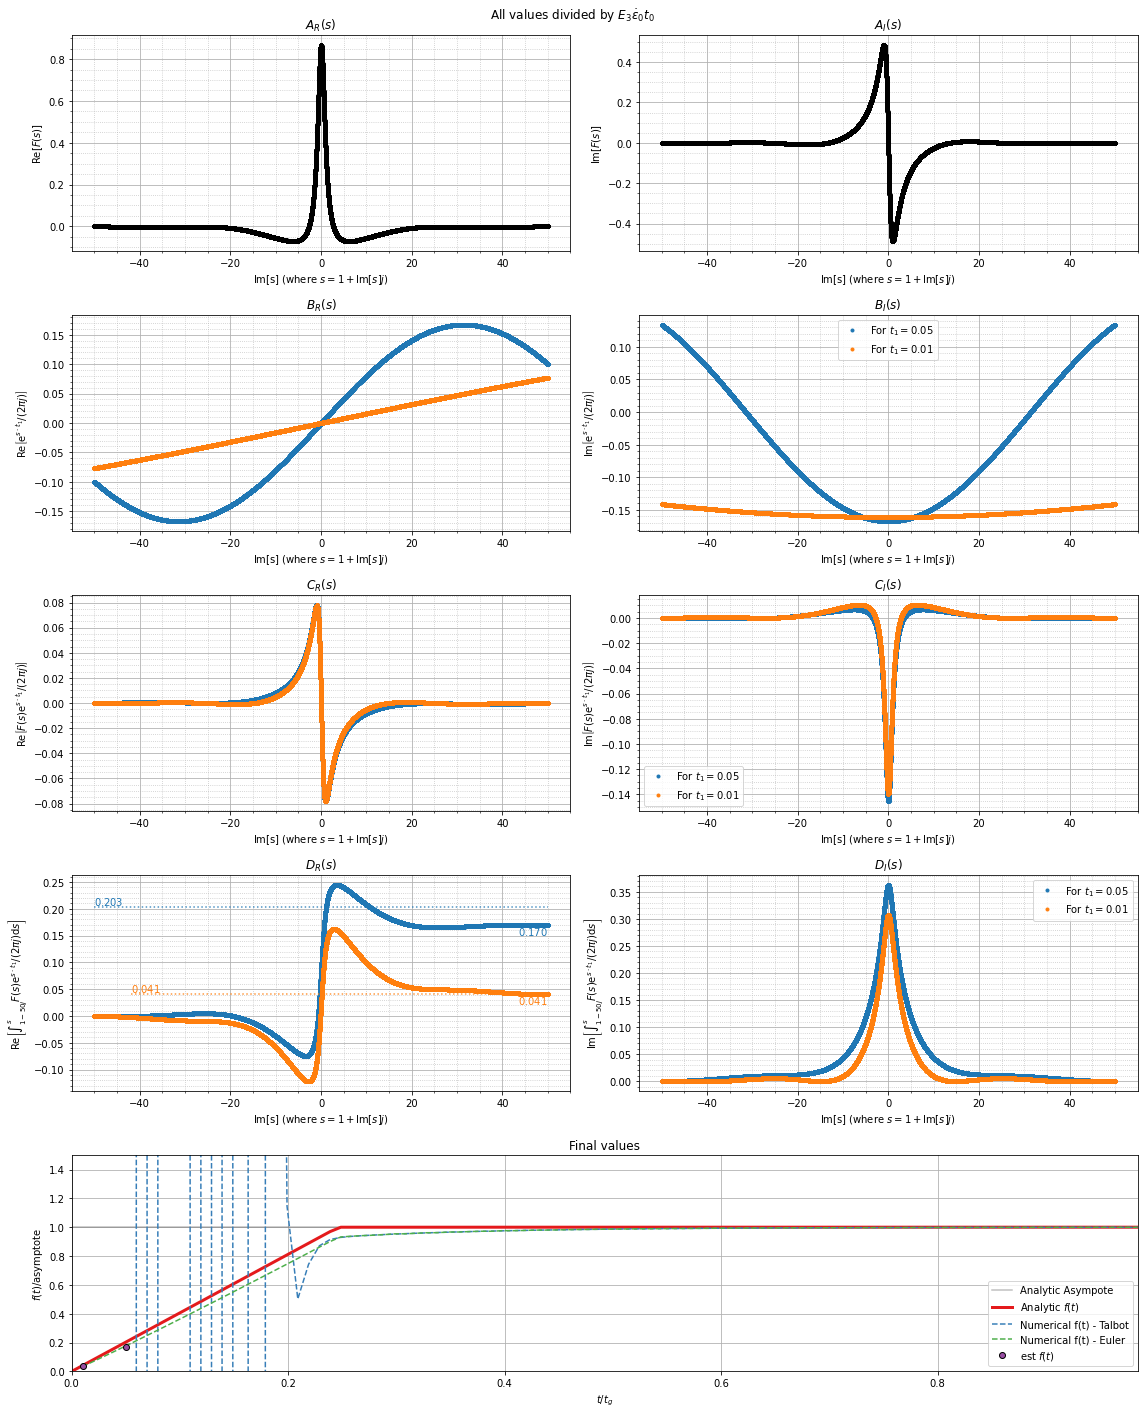

In [24]:
#@title Steps of inverse laplace of Cohen

importlib.reload(viscoporoelastic_model)
importlib.reload(inverting)

from viscoporoelastic_model import CohenModel, getCohenModelModified

param_name, param_name_latex = "v31", "\nu_{31}"
param_vals = np.array([0.707])

if param_name_latex is None:
    param_name_latex = param_name
VPEs = [(getCohenModelModified(**{param_name:param_val}), f"For ${param_name_latex}={np.round(param_val,2)}$") for param_val in param_vals]

do_plot = True  #@param {type: "boolean"}
s_real = 1 #@param {type:"slider", min:-10, max:10, step:0.1}
s_imag_width = 50  #@param {type:"number"}
(s, ds)=np.linspace(start=s_real-1j*s_imag_width, stop=s_real+1j*s_imag_width, 
                    num=100000, endpoint=True, retstep=True)

t1 = np.array([.05, 0.01])

t0_tg = VPEs[0][0].t0_tg
tg = VPEs[0][0].tg


func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]


plot_s = np.imag(s[...,None])
yss = []
row_namess = []

for ind, (vpe, label) in enumerate(VPEs):
    asymptote_analyt = (vpe.E3*vpe.strain_rate*vpe.t0_tg*tg)
    # The [...,None] index allows t1 to be either a single value (returns single value) or a matrix (returns matrix)
    ys = [
          vpe.laplace_value(s, dimensional=True)/asymptote_analyt, 
          np.exp(s[...,None]*t1)/(2j*np.pi)
          ]
    ys.append( (ys[0].T*ys[1].T).T )

    """ys.append(sp.integrate.quad( 
        (lambda s: 1j*vpe.laplace_value(s, dimensional=True)/asymptote_analyt*np.exp(s[...,None]*t1)/(2j*np.pi))
         ))"""

    """
    for t1_val in t1:
        val, err = sp.integrate.quad( 
                (lambda s_i: 1j*vpe.laplace_value(s_i*1j+1, dimensional=True)/asymptote_analyt*np.exp( (s_i*1j+1)*t1_val)/(2j*np.pi)),
                -50, 50
                )"""
        
    #ys.append( np.cumsum(ys[-1], axis=0)*ds )
    ys.append( sp.integrate.cumtrapz(ys[-1], axis=0)*ds )

    for indt,t1_val in enumerate(t1):
        # double check the last value with a different method integrate.quad
        ys[-1][-1,indt]=sp.integrate.quad(
                (lambda s_i: 1j*vpe.laplace_value(s_i*1j+1, dimensional=True)/asymptote_analyt*np.exp( (s_i*1j+1)*t1_val)/(2j*np.pi)),
                -50, 50
                )[0]



    # No dollar signs ($) here - added later
    row_names = [r"F(s)", 
                 r"\mathrm{e}^{s \cdot t_1}/(2 \pi j)"
                 #"\frac{exp(s \cdot t1)}{2j\cdot \pi}"
                 ]
    row_names.append( row_names[0]+row_names[1] )
    row_names.append( r"\int_{"+f"{np.min(s):.0f}" +r"}^{s}" + row_names[-1] + r" \mathrm{d}s")
    #row_names.append( r"\int_{-\infty}^{s}" + row_names[-1] + " ds")
    yss.append(ys)
    row_namess.append(row_names)

    print(f"t1={t1}")
    print(np.sum(np.real(ds*ys[2]), axis=0))
    print(np.sum(np.imag(ds*ys[2]), axis=0), " j" )
    #print( *zip(t1, np.real_if_close(np.sum(ds*ys[2], axis=0) ) )  )
    print()
    

    integrand_vals = ds*ys[2]
    inv_laplace_integ = np.sum(ds*ys[2], axis=0)
    inv_laplace_integ_re = np.real_if_close(inv_laplace_integ)
    analytic_values = vpe.inverted_value(t=t1*vpe.tg) / asymptote_analyt

    df_params = pd.DataFrame({
        "t/tg": t1,
        "f(t)": analytic_values,
        **{
        #f"L-1[F(s)]_using_sum{ind}": inv_laplace_integ_re,
        #f"RawError{ind}": inv_laplace_integ_re-analytic_values,
        f"PercentError{ind}": np.round((inv_laplace_integ_re-analytic_values)/analytic_values*100, 1)
        for ind, inv_laplace_integ_re in enumerate(
            [
             np.real_if_close(np.sum(ds*ys[2], axis=0) ),
             np.real_if_close(np.trapz(ys[2],dx=ds,axis=0) ),
            ]
            )
        },
        "LastPlotted": np.real_if_close(ys[3][-1,:]),
        #"Re":np.real(inv_laplace_integ),
        #"Im":np.imag(inv_laplace_integ),
        }, 
        index=[f"{vpe.get_model_name()} - t1={t1_val:.2f}" for ind, t1_val in enumerate(t1)]
        )
    display(df_params)
    


if do_plot:
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,20),
                        subplot_kw={
                            #"sharex":"all"
                            })

    for ax in axs.flat[0:-2]:  # Don't do the final two, which will be merged
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ##ax.set_xlabel("$Im[s]=(s-Re[s])/i$, " + f"Re[s]={s_real}")
        #ax.set_xlabel(r"$\mathrm{Im\left[s\right]}$ ($\mathrm{Re}\left[s\right]="+f"{s_real}$)")
        ax.set_xlabel(r"$\mathrm{Im\left[s\right]}$ (where $s="+f"{s_real}"+r"+\mathrm{Im}\left[s\right]j$)")

    #plt.suptitle(f"$s={s_real}+"+r"\mathrm{Im}\left[s\right]j$")
    #fig.supxlabel(f"Component of complex output")  # requires matplotlib 3.4

    gs = axs.flat[-2].get_gridspec()  #axs[-1,-2].get_gridspec()  #
    # remove the underlying axes
    for ax in axs[-1,:]: #ax in axs.flat[-2:0]:
        ax.remove()
    axbig = fig.add_subplot(gs[-1, -2:])
    axbig.grid(which="major")
    axbig.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    
    t_plot = np.linspace(0, 4*vpe.t0_tg, num=100,endpoint=True)
    analytic_values_plot = vpe.inverted_value(t=t_plot*vpe.tg) / asymptote_analyt
    asymptote_approx = vpe.inverted_value(t=np.array([5*vpe.tg])) / asymptote_analyt

    # Make this plot have a different colorscheme than the other plots to avoid confusion
    axbig.set_prop_cycle(color=plt.cm.Set1(np.linspace(0,1,9)))
    axbig.plot([t_plot[0],t_plot[-1]], 
               [asymptote_approx, asymptote_approx], 
               "k-", alpha=0.25, label="Analytic Asympote")
    
    axbig.plot(t_plot, analytic_values_plot, "-", label="Analytic $f(t)$", lw=3)
    axbig.plot(t_plot[int(len(t_plot)/25):], 
                inverting.talbot_inversion(vpe.laplace_value, 
                                            t_plot[int(len(t_plot)/25):])/asymptote_analyt, "--", label="Numerical f(t) - Talbot")
    axbig.plot(t_plot, inverting.euler_inversion(vpe.laplace_value, t_plot)/asymptote_analyt, "--", label="Numerical f(t) - Euler")
    axbig.plot(t1, ys[3][-1,:],"o", mec="k", label="est $f(t)$")

    axbig.set_xlabel("$t/t_g$")
    axbig.set_ylabel(r"$f(t)/$asymptote")
    axbig.set_xlim([0, np.max(t_plot)])
    axbig.set_ylim([0, np.max(analytic_values_plot)*1.5 ])
    axbig.set_title("Final values")
    axbig.legend()


    for (ys, row_names) in zip(yss, row_namess):  # for each model
        for ind,y in enumerate(ys):  # for each row
            if len(plot_s) == len(y) +1:
                plot_s_ = get_midpoint(plot_s)
            else:
                plot_s_ = plot_s
            axs.flat[0+ind*2].plot(plot_s_, np.real(y), "k." if y.ndim<=1 else ".")
            axs.flat[1+ind*2].plot(plot_s_, np.imag(y), "k." if y.ndim<=1 else ".")
            axs.flat[0+ind*2].set_ylabel(r"$\mathrm{Re} \left[" +f"{row_names[ind]}"+r"\right]$")
            axs.flat[1+ind*2].set_ylabel(r"$\mathrm{Im} \left[" +f"{row_names[ind]}"+r"\right]$")
            
            #axs.flat[0+ind*2].set_title("$F_{"+str(ind)+",R"+"}(s)$" )
            #axs.flat[1+ind*2].set_title("$F_{"+str(ind)+",I"+"}(s)$" )
            axs.flat[0+ind*2].set_title("$"+"ABCDEFGH"[ind]+"_R(s)$" )
            axs.flat[1+ind*2].set_title("$"+"ABCDEFGH"[ind]+"_I(s)$" )

            if y.ndim>1:
                axs.flat[1+ind*2].legend([f"For $t_1={t1_val:.2f}$" for t1_val in t1 ])
        
        # put this OUTSIDE the inner for loop
        #Draw horizontal line where the analytic value should be
        axs.flat[0+ind*2].set_prop_cycle(None)  # Resets the color cycle so colors of lines match the colors of plot
        # label_x is a column vector
        label_x = (np.min(plot_s)+np.arange(len(analytic_values))*0.08*(np.max(plot_s)-np.min(plot_s)))[...,np.newaxis]
        
        axs.flat[0+ind*2].plot(
            #plot_s[ np.array([0,-1])],
            np.append(label_x,np.full_like(label_x, np.max(plot_s)), axis=1).T,
            #np.repeat(plot_s[(-1)][...,None],2), 
            np.repeat(analytic_values[...,None], 2, axis=1).T, 
            ":", alpha=0.8,   # put 0.5 in case overlap
            )
        for ind, t1_val in enumerate(t1):
            # Gets the color cycle in use, then access the nth item
            this_color = plt.rcParams["axes.prop_cycle"].by_key()["color"][ind]
            # Minimize the risk of overlap by spacing the text out horizontally (at least the left ones)
            this_left_x = np.min(plot_s)+ind*0.08*(np.max(plot_s)-np.min(plot_s))
            # Annotate analytic value on left
            axs.flat[-2*2].annotate(
                f"${analytic_values[ind]:0.3f}$", 
                (label_x[ind], analytic_values[ind]), xycoords="data", 
                va='bottom', ha="left", color=this_color, fontweight="bold")
            
            # Annotate approx value on right
            axs.flat[-2*2].annotate(
                f"${np.real(ys[3][-1,ind]):0.3f}$", (np.max(plot_s), np.real(ys[3][-1,ind])),
                xycoords="data", va='top', ha="right", color=this_color)
            print()
            print(analytic_values[ind])
        
    plt.suptitle(r"All values divided by $E_3\dot{\varepsilon}_0 t_0$")
    fig.tight_layout()

df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

### Steps of inverse laplace of Cohen - alternating


In [ ]:
for t1_val in t1:
    val, err = sp.integrate.quad( 
            (lambda s_i: vpe.laplace_value(s_i*1j+1, dimensional=True)/asymptote_analyt*np.exp( (s_i*1j+1)*t1_val)/(2j*np.pi)),
            -50, 50
            )

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


(0.0, 3.554573108057543e-15)

In [ ]:
for indt,t1_val in enumerate(np.array([.01, 0.05])):
        print(t1_val,sp.integrate.quad( 
                (lambda s_i: -np.imag(vpe.laplace_value(s_i*1j+1, dimensional=True)/asymptote_analyt*np.exp( (s_i*1j+1)*t1_val)/(2j*np.pi))),
                -500, 500
                ), vpe.inverted_value(t1_val*vpe.tg))

<IPython.core.display.Javascript object>

0.01 (0.04222072610518466, 2.531304135470455e-10) 0.20546254375271467
0.05 (0.20771758980746682, 8.120310474971352e-12) 0.9069126626262765


In [92]:
ys[-1][100:,1].real.shape

<IPython.core.display.Javascript object>

(100,)

In [99]:
#asymptote_analyt

#sort_indices = np.argsort( np.abs(ys[2].real))
#ys[2][sort_indices].real.shape
#sort_indices.shape
#ys[2].shape
#ys[2][sort_indices].real

sort_indices = np.argsort( np.abs(plot_s) + 1e-8*np.sign(plot_s))
#plot_s[sort_indices]
np.zeros_like(plot_s[plot_s<0]).shape
#ys[0].shape
#plot_s[plot_s<0].shape + (2,)
ys[2].shape[1:]
pd.DataFrame([
              sort_indices,
              plot_s[sort_indices],
              *[ys[2][sort_indices][:,ind].real for ind in range(ys[2].shape[1])],
              *[ys[3][100:,ind].real for ind in range(ys[3].shape[1])],
              ] )

#np.cumsum(ys[2][sort_indices], axis=0).real.T
ds

<IPython.core.display.Javascript object>

1.0101010101010102j

<IPython.core.display.Javascript object>

t1=[0.05 0.01]
[0.19765306 0.04693791]
[4.17607572e-16 4.42320605e-16]  j



/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


,t/tg,f(t),PercentError0,PercentError1,PercentError2,LastPlotted
CohenModelModified - t1=0.05,0.05,0.477322,-58.6,-58.6,-100.0,0.197653
CohenModelModified - t1=0.01,0.01,0.108138,-56.6,-56.5,-100.0,0.046938


/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:154: RuntimeWarning: divide by zero encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:154: RuntimeWarning: invalid value encountered in true_divide
  F_s_val, is_inf = F_s(beta_mesh / t_mesh, return_error_inds=True)
/content/gdrive/My Drive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/inverting.py:163: RuntimeWarning: divide by zero encountered in true_divide
  ilt = 10 ** (Marg/3) / times * sum (eta_mesh * real(F_s(beta_mesh / t_mesh)), ax


0.47732245401382967

0.1081381809224814


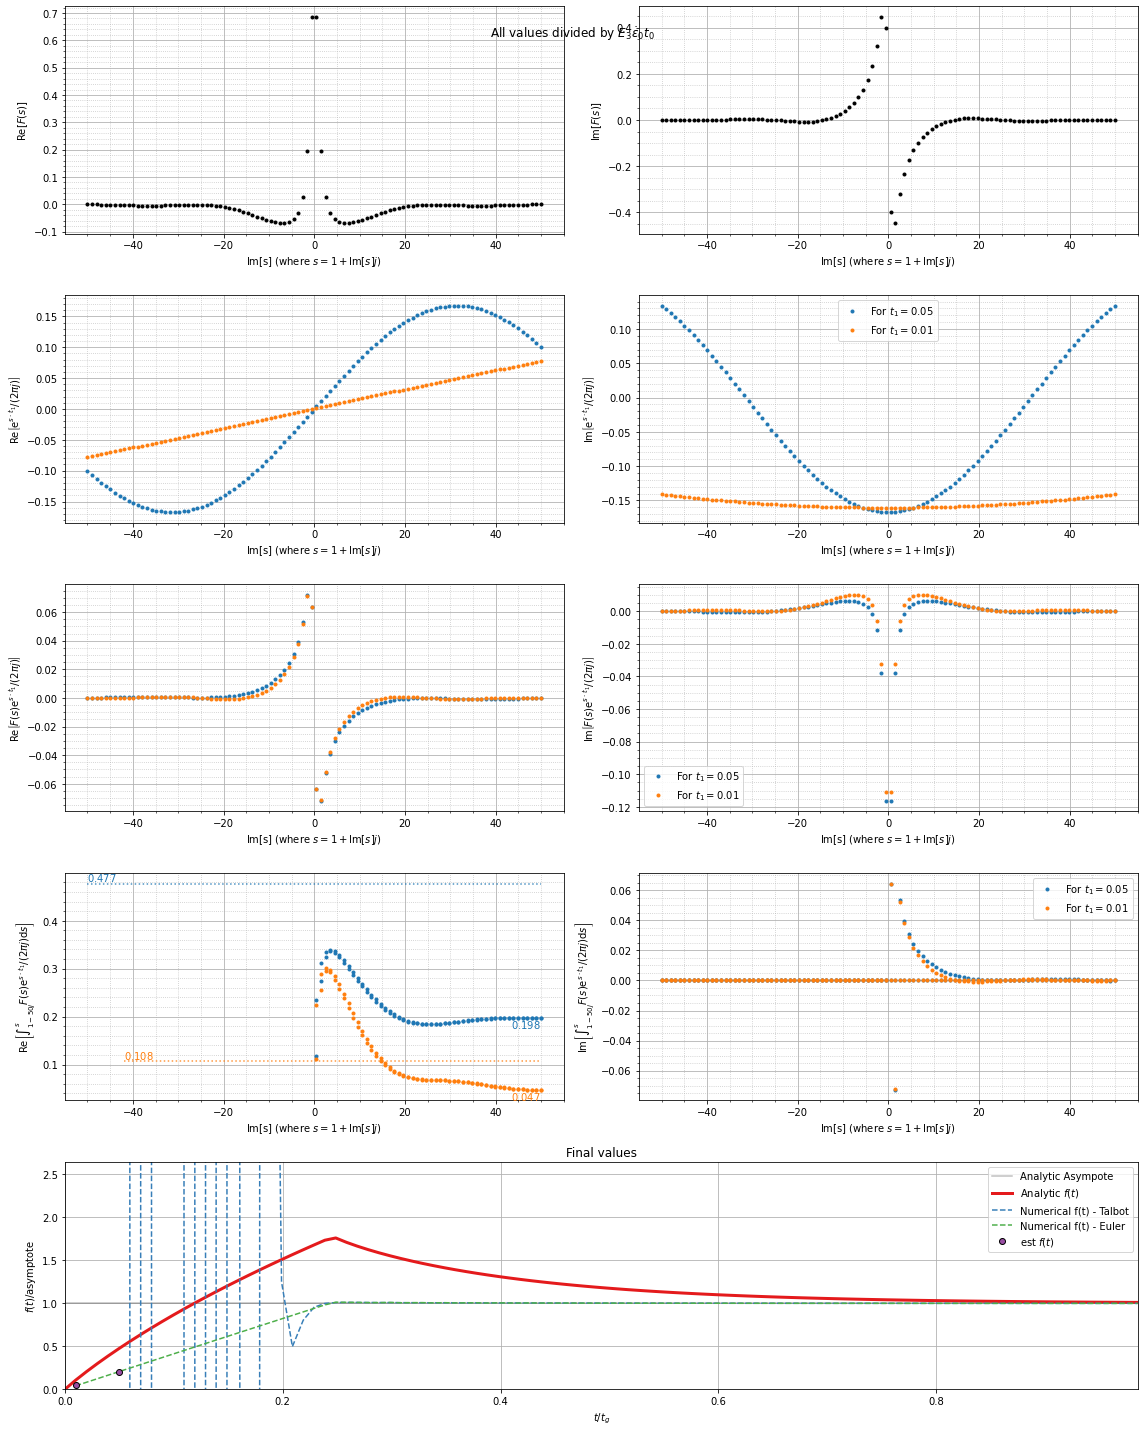

In [82]:

importlib.reload(viscoporoelastic_model)
importlib.reload(inverting)

from viscoporoelastic_model import CohenModel, getCohenModelModified

param_name, param_name_latex = "v31", "\nu_{31}"
param_vals = np.array([np.sqrt(1/2)])  #np.linspace(0,1,10,endpoint=True)
param_vals = np.array([0.45])

VPEs = [
        (CohenModel(), fr"$Cohen$"), 
        #(getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") 
        ]
if param_name_latex is None:
    param_name_latex = param_name
VPEs = [(getCohenModelModified(**{param_name:param_val}), f"For ${param_name_latex}={np.round(param_val,2)}$") for param_val in param_vals]

do_plot = True  #@param {type: "boolean"}
s_real = 1 #@param {type:"slider", min:-10, max:10, step:0.1}
s_imag_width = 50  #@param {type:"number"}
(s, ds)=np.linspace(start=s_real-1j*s_imag_width, stop=s_real+1j*s_imag_width, 
                    num=100, endpoint=True, retstep=True)
#t1 = np.array([.01,.1, 1.5])  # nondimensional
#t1 = np.array([.01,.1, 1.0])  # nondimensional
#t1 = np.array([.05, 0.246184, 0.5])
#t1 = np.concatenate( (np.arange(0.01,0.1,0.01), np.arange(.1,2,.1)) )  # nondimensional
#t1 = np.array([.01, 0.05, 0.246184])
t1 = np.array([.05, 0.01])

t0_tg = VPEs[0][0].t0_tg
tg = VPEs[0][0].tg


func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]


#plot_s = np.imag(s[...,None])
plot_s = np.imag(s)   # make one dim array, not 2+, for convenience
yss = []
row_namess = []

for ind, (vpe, label) in enumerate(VPEs):
    asymptote_analyt = (vpe.E3*vpe.strain_rate*vpe.t0_tg*tg)
    # The [...,None] index allows t1 to be either a single value (returns single value) or a matrix (returns matrix)
    ys = [
          vpe.laplace_value(s, dimensional=True)/asymptote_analyt, 
          np.exp(s[...,None]*t1)/(2j*np.pi)
          ]
    ys.append( (ys[0].T*ys[1].T).T )
    """ys.append(sp.integrate.quad( 
        (lambda s: 1j*vpe.laplace_value(s, dimensional=True)/asymptote_analyt*np.exp(s[...,None]*t1)/(2j*np.pi))
         ))"""

    """
    for t1_val in t1:
        val, err = sp.integrate.quad( 
                (lambda s_i: 1j*vpe.laplace_value(s_i*1j+1, dimensional=True)/asymptote_analyt*np.exp( (s_i*1j+1)*t1_val)/(2j*np.pi)),
                -50, 50
                )"""

    """ys.append( sp.integrate.cumtrapz(ys[-1], axis=0)*ds )
    for indt,t1_val in enumerate(t1):
        # double check the last value with a different method integrate.quad
        ys[-1][-1,indt]=sp.integrate.quad(
                (lambda s_i: 1j*vpe.laplace_value(s_i*1j+1, dimensional=True)/asymptote_analyt*np.exp( (s_i*1j+1)*t1_val)/(2j*np.pi)),
                -50, 50
                )[0]"""

    # add the sign component so that there is a predictable order when there are two values to sort that are opposite sign
    sort_indices = np.argsort( np.abs(plot_s) + 1e-8*np.sign(plot_s))
    plot_s[sort_indices]
    #ys.append( sp.integrate.cumtrapz(ys[-1], axis=0)*ds )
    ys.append( np.concatenate((
        # width of plot_s<0, but must keep height same to concat
        #np.full( (plot_s[plot_s<0].shape + ys[-1].shape[1:]), np.nan ),  # put leading zeros
        np.full(ys[2][sort_indices].shape, np.nan),
        np.cumsum(ys[2][sort_indices], axis=0)*ds
        )) )


    # No dollar signs ($) here - added later
    row_names = [r"F(s)", 
                 r"\mathrm{e}^{s \cdot t_1}/(2 \pi j)"
                 #"\frac{exp(s \cdot t1)}{2j\cdot \pi}"
                 ]
    row_names.append( row_names[0]+row_names[1] )
    row_names.append( r"\int_{"+f"{np.min(s):.0f}" +r"}^{s}" + row_names[-1] + r" \mathrm{d}s")
    #row_names.append( r"\int_{-\infty}^{s}" + row_names[-1] + " ds")
    yss.append(ys)
    row_namess.append(row_names)

    print(f"t1={t1}")
    print(np.sum(np.real(ds*ys[2]), axis=0))
    print(np.sum(np.imag(ds*ys[2]), axis=0), " j" )
    #print( *zip(t1, np.real_if_close(np.sum(ds*ys[2], axis=0) ) )  )
    print()
    

    integrand_vals = ds*ys[2]
    inv_laplace_integ = np.sum(ds*ys[2], axis=0)
    inv_laplace_integ_re = np.real_if_close(inv_laplace_integ)
    analytic_values = vpe.inverted_value(t=t1*vpe.tg) / asymptote_analyt

    df_params = pd.DataFrame({
        "t/tg": t1,
        "f(t)": analytic_values,
        **{
        #f"L-1[F(s)]_using_sum{ind}": inv_laplace_integ_re,
        #f"RawError{ind}": inv_laplace_integ_re-analytic_values,
        f"PercentError{ind}": np.round((inv_laplace_integ_re-analytic_values)/analytic_values*100, 1)
        for ind, inv_laplace_integ_re in enumerate(
            [
             np.real_if_close(np.sum(ds*ys[2], axis=0) ),
             np.real_if_close(np.trapz(ys[2],dx=ds,axis=0) ),
             np.array([sp.integrate.quad( 
                (lambda s_i: vpe.laplace_value(s_i*1j+1, dimensional=True)/asymptote_analyt*np.exp( (s_i*1j+1)*t1_val)/(2j*np.pi)),
                -50, 50
                )[0] for t1_val in t1])
            ]
            )
        },
        "LastPlotted": np.real_if_close(ys[3][-1,:]),
        #"Re":np.real(inv_laplace_integ),
        #"Im":np.imag(inv_laplace_integ),
        }, 
        index=[f"{vpe.get_model_name()} - t1={t1_val:.2f}" for ind, t1_val in enumerate(t1)]
        )
    display(df_params)
    


if do_plot:
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,20),
                        subplot_kw={
                            #"sharex":"all"
                            })

    for ax in axs.flat[0:-2]:  # Don't do the final two, which will be merged
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ##ax.set_xlabel("$Im[s]=(s-Re[s])/i$, " + f"Re[s]={s_real}")
        #ax.set_xlabel(r"$\mathrm{Im\left[s\right]}$ ($\mathrm{Re}\left[s\right]="+f"{s_real}$)")
        ax.set_xlabel(r"$\mathrm{Im\left[s\right]}$ (where $s="+f"{s_real}"+r"+\mathrm{Im}\left[s\right]j$)")


    gs = axs.flat[-2].get_gridspec()  #axs[-1,-2].get_gridspec()  #
    # remove the underlying axes
    for ax in axs[-1,:]: #ax in axs.flat[-2:0]:
        ax.remove()
    axbig = fig.add_subplot(gs[-1, -2:])
    axbig.grid(which="major")
    axbig.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    
    t_plot = np.linspace(0, 4*vpe.t0_tg, num=100,endpoint=True)
    analytic_values_plot = vpe.inverted_value(t=t_plot*vpe.tg) / asymptote_analyt
    asymptote_approx = vpe.inverted_value(t=np.array([5*vpe.tg])) / asymptote_analyt

    # Make this plot have a different colorscheme than the other plots to avoid confusion
    axbig.set_prop_cycle(color=plt.cm.Set1(np.linspace(0,1,9)))
    axbig.plot([t_plot[0],t_plot[-1]], 
               [asymptote_approx, asymptote_approx], 
               "k-", alpha=0.25, label="Analytic Asympote")
    
    axbig.plot(t_plot, analytic_values_plot, "-", label="Analytic $f(t)$", lw=3)
    axbig.plot(t_plot[int(len(t_plot)/25):], 
                inverting.talbot_inversion(vpe.laplace_value, 
                                            t_plot[int(len(t_plot)/25):])/asymptote_analyt, "--", label="Numerical f(t) - Talbot")
    axbig.plot(t_plot, inverting.euler_inversion(vpe.laplace_value, t_plot)/asymptote_analyt, "--", label="Numerical f(t) - Euler")
    axbig.plot(t1, ys[3][-1,:],"o", mec="k", label="est $f(t)$")

    axbig.set_xlabel("$t/t_g$")
    axbig.set_ylabel(r"$f(t)/$asymptote")
    axbig.set_xlim([0, np.max(t_plot)])
    axbig.set_ylim([0, np.max(analytic_values_plot)*1.5 ])
    axbig.set_title("Final values")
    axbig.legend()


    for ys, row_names in zip(yss, row_namess):  # for each model
        for ind,y in enumerate(ys):  # for each row
            if len(plot_s) == len(y) +1:
                plot_s_ = get_midpoint(plot_s)
            elif len(plot_s)*2 == len(y):
                plot_s_ = np.repeat(plot_s,2)  # [-1,0,1] becomes [-1,-1,0,0,1,1] etc
            else:
                plot_s_ = plot_s
            axs.flat[0+ind*2].plot(plot_s_, np.real(y), "k." if y.ndim<=1 else ".")
            axs.flat[1+ind*2].plot(plot_s_, np.imag(y), "k." if y.ndim<=1 else ".")
            axs.flat[0+ind*2].set_ylabel(r"$\mathrm{Re} \left[" +f"{row_names[ind]}"+r"\right]$")
            axs.flat[1+ind*2].set_ylabel(r"$\mathrm{Im} \left[" +f"{row_names[ind]}"+r"\right]$")
            if y.ndim>1:
                axs.flat[1+ind*2].legend([f"For $t_1={t1_val:.2f}$" for t1_val in t1 ])
        
        # put this OUTSIDE the inner for loop
        #Draw horizontal line where the analytic value should be
        axs.flat[0+ind*2].set_prop_cycle(None)  # Resets the color cycle so colors of lines match the colors of plot
        # label_x is a column vector
        label_x = (np.min(plot_s)+np.arange(len(analytic_values))*0.08*(np.max(plot_s)-np.min(plot_s)))[...,np.newaxis]
        
        axs.flat[0+ind*2].plot(
            #plot_s[ np.array([0,-1])],
            np.append(label_x,np.full_like(label_x, np.max(plot_s)), axis=1).T,
            #np.repeat(plot_s[(-1)][...,None],2), 
            np.repeat(analytic_values[...,None], 2, axis=1).T, 
            ":", alpha=0.8,   # put 0.5 in case overlap
            )
        for ind, t1_val in enumerate(t1):
            # Gets the color cycle in use, then access the nth item
            this_color = plt.rcParams["axes.prop_cycle"].by_key()["color"][ind]
            # Minimize the risk of overlap by spacing the text out horizontally (at least the left ones)
            this_left_x = np.min(plot_s)+ind*0.08*(np.max(plot_s)-np.min(plot_s))
            # Annotate analytic value on left
            axs.flat[-2*2].annotate(
                f"${analytic_values[ind]:0.3f}$", 
                (label_x[ind], analytic_values[ind]), xycoords="data", 
                va='bottom', ha="left", color=this_color, fontweight="bold")
            
            # Annotate approx value on right
            axs.flat[-2*2].annotate(
                f"${np.real(ys[3][-1,ind]):0.3f}$", (np.max(plot_s), np.real(ys[3][-1,ind])),
                xycoords="data", va='top', ha="right", color=this_color)
            print()
            print(analytic_values[ind])
        
    plt.suptitle(r"All values divided by $E_3\dot{\varepsilon}_0 t_0$")
    fig.tight_layout()



In [74]:
#ys[3]
get_midpoint(plot_s).shape
#abs(plot_s_).argmin(axis=0)
#plot_s_[ind][0]

#pd.DataFrame( [ [plot_s_[ind][0].real, ys[3][ ind,0 ].real]  for ind in abs(plot_s_-goal).argmin(axis=0) ] )

goals = [0, 1, 5, 50]
inds = [abs(plot_s_-goal).argmin() for goal in goals]
inds.insert(1,inds[0]+1)
inds.insert(0,inds[0]-1)
pd.DataFrame( [ np.round(plot_s_[inds][:,0].real,3), ys[3][ inds,0 ].real ] )



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,0,1,2,3,4,5
0,-1.010000,0.000000,1.010000,1.010000,5.051000,49.495000
1,0.039973,0.157654,0.235697,0.235697,0.263269,0.199609


# Complex input, but varying only real comp, of bessel functions

<IPython.core.display.Javascript object>

At s=-14.239+0.000j, output was -0.403 which plotted as -0.403
At s=-7.232+0.000j, output was -0.903+0.504j which plotted as -0.903


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will a

(-5.0, 10.0)

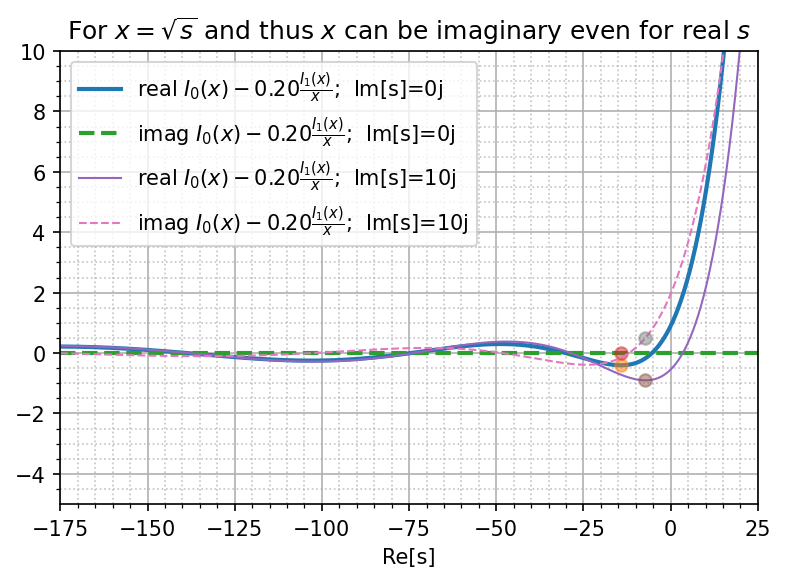

In [ ]:
use_rt = True  #@param {type:"boolean"}
alpha = 0.9 #@param {type:"slider", min:0, max:1, step:0.1}
imaginary_comp = 10  #@param {type:"slider", min:-10, max:10, step:0.1}

def angle_or_nan(x): 
    x = np.real_if_close(x)  # necesssary or alternating between -1e-9j and 1e-9j would give alternating angles for example
    return np.where(np.abs(x)<1e-8, np.nan, np.angle(x)) 
use_abs_polar = False #@param {type:"boolean"}
if use_abs_polar:
    methods_dash = [(np.abs, "-"), (angle_or_nan, "--")]
else:
    methods_dash = [(np.real, "-"), (np.imag, "--")]

if use_rt:
    s=np.linspace(start=-100-75, stop=100-75, num=1000, endpoint=True)+0j
else:
    s=np.linspace(start=-10, stop=10, num=1000, endpoint=True)+0j


fig = plt.figure()
fig.set_dpi(150)

if use_rt:
    plt.title(r"For $x=\sqrt{s}$ and thus $x$ can be imaginary even for real $s$")
else:
    plt.title(r"For $x=s$")

for imag_comp in [0, imaginary_comp]:
    if use_rt:
        x = np.sqrt(s+0j + 1j*imag_comp)
    else:
        x = s + 1j*imag_comp

    yuneven = I0(x)-alpha*I1(x)/x
    argminind = np.argmin(yuneven)
    print(f"At s={s[argminind]:.3f}, output was {np.real_if_close(yuneven[argminind]):.3f} which plotted as {ychange(yuneven[argminind]):.3f}" )
    for method, dash in methods_dash:
        plt.plot(s, method(yuneven),dash, linewidth=(2 if imag_comp==0 else 1), 
                label=f"{method.__name__} $I_0(x)-{alpha:.2f}"+r"\frac{I_1(x)}{x}$;  "+f"Im[s]={imag_comp}j")
        plt.plot(s[argminind], method(yuneven[argminind]),"o",alpha=0.5)


plt.xlabel("Re[s]")

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.xlim([np.min(s),np.max(s)])

plt.ylim([-5,10])



# Summary
## For $x=s$ on real s axis. 
* So $I_0(x)-\frac{I_1(x)}{x}$ is a concave up paraboloid when you say $x$ is real and it is plotted against $s=x$.    


## However, when you let $x=\sqrt{s}$, then even on the real $s$ axis: 
* The **input, $x$, to the bessel functions** can be (purely) **imaginary** or real
* $I_0(\sqrt{s})$ is still always real  
  * However, it becomes  sinusoidal for $s<0$ .  
  * It monotonically increasing (like an exponential) for $s>0$.
* $I_1(\sqrt{s})$ is purely **imaginary** or real.  
  * Thus $\frac{I_1(\sqrt{s})}{\sqrt{s}}$ is always real
  * Additionally it is monotonically increasing and approaches 0 as $s\to-\infty$
* $I_1(\sqrt{s})-\frac{I_1(\sqrt{s})}{\sqrt{s}}$ is real
* $I_1(\sqrt{s})-\alpha\frac{I_1(\sqrt{s})}{\sqrt{s}}$ is real (tested only for $0≤\alpha≤1$)
* Then the plot of $I_0(\sqrt{s})-\frac{I_1(\sqrt{s})}{\sqrt{s}}$ against $s=x^2$ is sinusoidal (but still real) for $s < 0$ and is monotonically increasing (like a positive exponential graph) for $s > 0$.  
  * There are no zeros for $s≥0$ of $I_0(\sqrt{s})-\alpha\frac{I_1(\sqrt{s})}{\sqrt{s}}$  (tested only for $0≤\alpha≤1$)
  * However there are some (infinite number?) of zeroes for $s < 0$
  * These zeros should be about the same as those for $I_0(\sqrt{s})$ as the $I_1$ term becomes negligible. 
  * Thus $\alpha$ should have negligible effect on the poles

For real (but either + or -) inputs to the bessel functions, there are no zeros for $I_0(x)-\alpha\frac{I_1(x)}{x}$ and for $0<\alpha≤1$. The output is always positive (and real) with a min at $x=0$.

## For $x=s$, then  on the (purely) imaginary $s$ axis: 


## For $x=\sqrt{s}$, then  on the (purely) imaginary $s$ axis: 

* Recall $\sqrt{i}=\frac{1+i}{\sqrt{2}}$
* Therefore, the inputs to the bessel functions will be complex


# Cohen Model plot

<IPython.core.display.Javascript object>

$Cohen$


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModel - Line #1,0.246184,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221


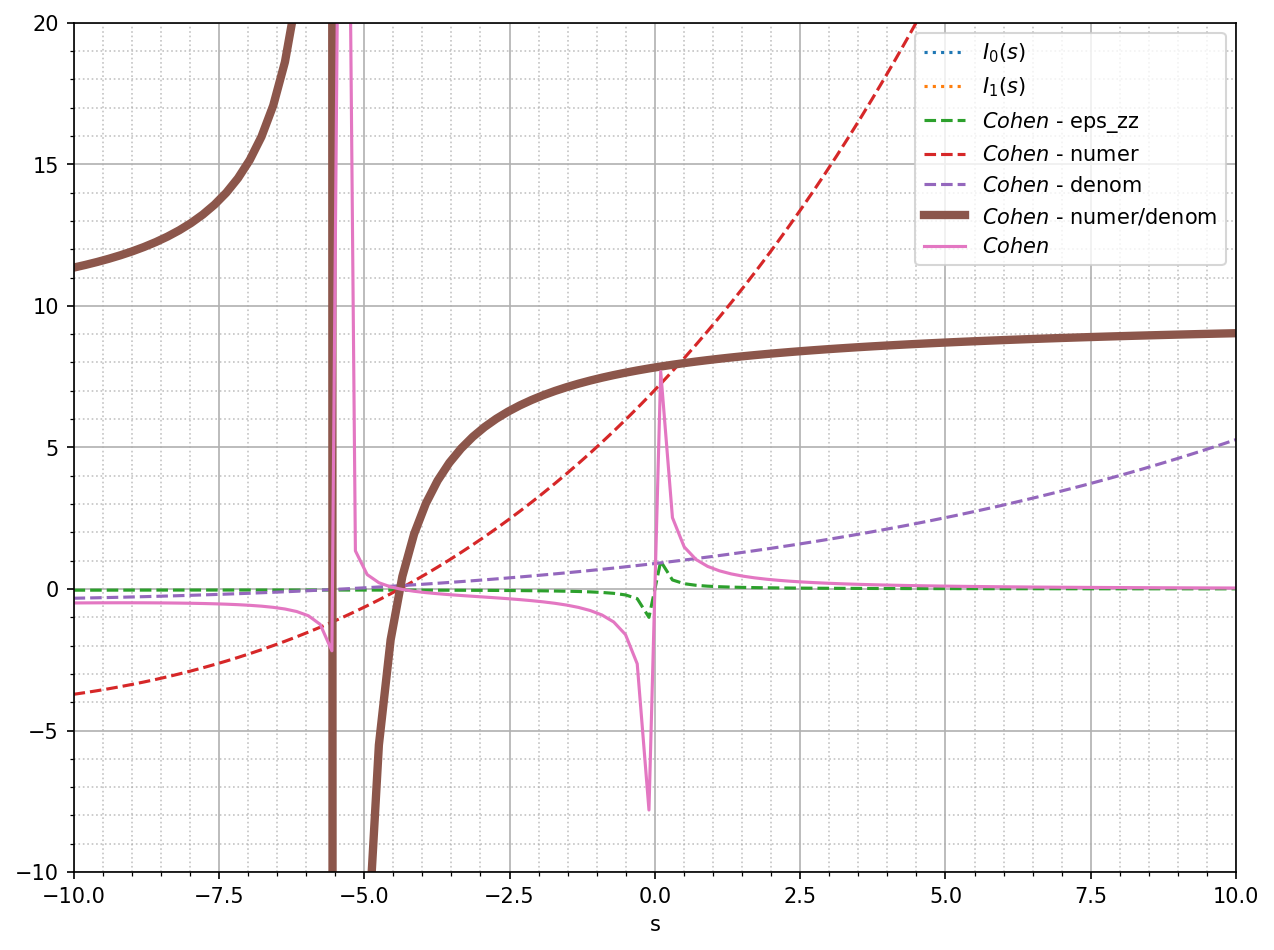

In [ ]:
exp = np.exp
sqrt = np.sqrt

VPEs = [(CohenModel(), fr"$Cohen$"), 
        #(getCohenModelModified(E1=3.5), fr"$Cohen, E_1=3.5$") 
        ]
    

def ychange(vals):
    return vals


s=np.linspace(start=-10, stop=10, num=100, endpoint=True)+0j
fig = plt.figure()
fig.set_figheight(7.5)
fig.set_figwidth(10)
fig.set_dpi(150)
for v in [0,1]:
    # Avoid plotting this by changing s axis (still keeps colors in legend though)
    plt.plot(s*0-100, ychange(Iv(s,v=v)),":", label=f"$I_{v}(s)$")

for vpe, label in VPEs:
    print(label)
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, C11, C12, C13, C33, C0, C1, C2 = vpe.get_calculable_constants()


    I1rts_s = I1(sqrt(s)) / sqrt(s)
    I0rts = I0(sqrt(s))
    eps_zz = strain_rate * tg * (1 - exp(-t0_tg * s))/ (s*s)
    numer = (C1*I0rts - C2*C0*I1rts_s)  #* (1 - exp(-t0_tg * s)) 
    denom = (I0rts - C0*I1rts_s)        #* s*s
    dimensionalize = (C11-C12)/2
    plt.plot(s,ychange(eps_zz),"--", label=label+": eps_zz")
    plt.plot(s,ychange(numer), "--", label=label+": numer")
    plt.plot(s,ychange(denom), "--", label=label+": denom")
    # ignore *dimensionalize for now
    plt.plot(s,ychange(numer/denom), label=label+" - numer/denom", linewidth=4)
    plt.plot(s,ychange(numer/denom*eps_zz), label=label)
    #plt.plot(s,ychange(vpe.laplace_value(s)), label=label, linewidth=4)

plt.xlabel("s")

plt.legend()
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.xlim([np.min(s),np.max(s)])
plt.ylim([-10,20])
plt.axes().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#plt.yscale('log')

df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

In [ ]:
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)
times_eval = np.array([1.0,0.8,0.6,0.4,0.3,0.24])
eval_vals = [vpe.inverted_value(times_eval*vpe.tg) for vpe, label in VPEs]
np.vstack([times_eval, eval_val])
df_eval = pd.DataFrame(np.vstack([times_eval, *eval_vals]).transpose(), columns=["t/tg",*[label for vpe, label in VPEs] ])

print()
display(df_eval)


<IPython.core.display.Javascript object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModel - Line #1,0.246184,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified - Line #2,0.246184,40.62,0.01,3.5,19,0.75,0.24,0.228779,0.565365,2.186544,8.649305,6.649305,3.671667,20.762400,0.231232,21.068372,36.889982


,t/tg,$Cohen$,"$Cohen, E_1=3.5$"
0,1.00,1.913299,1.905023
1,0.80,1.938857,1.914503
2,0.60,2.013534,1.941874
3,0.40,2.232027,2.021013
4,0.30,2.473256,2.107653
5,0.24,2.638236,2.135801


# Complex plane input

In [ ]:
#@title Settings for calculations for complex figure

#methods = [ np.real, np.imag, np.abs, np.angle]  # convert complex to float
methods = [ np.real, np.imag, None]  #np.real_if_close]
method_output_formats = ["","j","",""]

#re_parts = np.arange(-3,3 +1)
#im_parts = np.arange(-2,2 +1)

#re_parts, re_step = np.linspace( -12,  12,num=12*2+1,endpoint=True,retstep=True)
#im_parts, im_step = np.linspace(  -8,   8,num= 8*2+1,endpoint=True,retstep=True)
re_parts, re_step = np.linspace( -100,   4,num=104*10+1, endpoint=True,retstep=True)
im_parts, im_step = np.linspace(  -20,  20,num=20*2*10+1,endpoint=True,retstep=True)

alpha = 0.2;

funcs = [ 
         #("I0",I0), 
         #("I1",I1), 
         #("I1/x",  lambda x: I1(x)/x) , 
         #(r"$I_0(x)-\alpha \frac{I_1(x)}{x}$",lambda x: I0(x)-alpha*I1(x)/x), 
         (r"$I_0(\sqrt{x})-\alpha \frac{I_1(\sqrt{x})}{\sqrt{x}}$",lambda x: I0(np.sqrt(x))-alpha*I1(np.sqrt(x))/np.sqrt(x)), 
         ("x", lambda x: x),
         #("e^x", lambda x: np.exp(x)) 
        ]


re_min = np.nanmin(re_parts)
re_max = np.nanmax(re_parts)
im_min = np.nanmin(im_parts)
im_max = np.nanmax(im_parts)
symmetric = [math.isclose(-re_min, re_max), math.isclose(-im_min, im_max)]
print(f"{re_min}->{re_max}, {im_min}j->{im_max}j")


<IPython.core.display.Javascript object>

-100.0->4.0, -20.0j->20.0j


In [ ]:
#@title Perform calculations for complex figure

re_grid, im_grid = np.meshgrid(re_parts, im_parts, sparse=False, indexing='xy')
input_grid = re_grid + im_grid*1j

outputs = [func(input_grid) for (func_name, func) in funcs]
outputs_hsv = [complex_array_to_rgb(output) for output in outputs]
#print( np.real(funcs[2][1](input_grid)) )

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in remainder
  if __name__ == '__main__':


In [ ]:
#@title Settings for complex figure

use_contourf = False
always_use_2D_colors = True
draw_text_spacing_re = 3*5  # should be positive. Make value 1 to draw every block.
draw_text_spacing_im = 3*5  # should be positive. Make value 1 to draw every block.
fig_size = (30, 30)

<IPython.core.display.Javascript object>

In [ ]:
#@title Draw complex figure

#methods = [ np.real, np.imag, None]  #np.real_if_close]
methods = [ None]

fig, axs = plt.subplots(nrows=len(funcs), ncols=len(methods), figsize=fig_size,
                        subplot_kw={
                            #'xticks': np.arange(len(re_parts)),
                            #'xticklabels': ["{:6.1f}".format(i) for i in re_parts ]
                            #'yticks': im_parts,
                            }
                        )



#for ind, (ax, method) in enumerate(zip(axs.flat, itertools.cycle(methods) )):
#    row_num, col_num = divmod(ind, len(methods))
#    output =  funcs[row_num][1](input_grid) 
for row_num, (func_name, func) in enumerate(funcs):
    output =  outputs[row_num]
    for col_num, method in enumerate(methods):
        t0 = time.time()
        ind = row_num*len(methods)+col_num
        #ax = axs[row_num, col_num]
        ax = axs.flat[ind]
        # trfm = transformed (i.e. method has been applied)
        output_trfm = output if method is None else method(output)
        if use_contourf:
            #ax.pcolormesh( re_grid, im_grid, output_trfm )
            ax.contourf( re_grid, im_grid, output_trfm, cmap='RdYlGn' )  #PuOr
        else:
            if always_use_2D_colors or np.any(np.iscomplex(output_trfm)):
                if method is None:
                    output_disp = outputs_hsv[row_num]
                elif method_output_formats[col_num].strip() in ["j","i"]:
                    output_disp = complex_array_to_rgb(output_trfm*1j)
                else:
                    output_disp = complex_array_to_rgb(output_trfm)
                print(f"Using rgb for plot at r={row_num}, c={col_num}")
                cmap_to_use = None
            else:
                output_disp = output_trfm
                print(f"NOT using rgb for plot at r={row_num}, c={col_num}")
                cmap_to_use = 'RdYlGn'

            fig=ax.imshow( output_disp,origin='lower', cmap=cmap_to_use,
                    extent=np.array([re_min-re_step/2,re_max+re_step/2,im_min-im_step/2,im_max+im_step/2]), #[re_min-0.5,re_max+0.5,im_min-0.5,im_max+0.5] #[-3.5,3.5,-2.5,2.5] 
                    vmin=-np.nanmax(np.abs(output_trfm)),
                    vmax=+np.nanmax(np.abs(output_trfm)),
                )    
        print(f"t1={time.time() - t0}")
            
        ax.set_xticks(re_parts-re_step/2, minor=True)
        ax.set_yticks(im_parts-im_step/2, minor=True)
        ax.grid(which="minor", color="lightgray", linestyle='--', linewidth=1)
        #ax.tick_params(which="minor", bottom=False, left=False)


        # Loop over data dimensions and create text annotations.
        for ind1, re_part in enumerate(re_parts):
            for ind2, im_part in enumerate(im_parts):
                # if re_parts has len 7
                # then indices [ 0, 1, 2, 3, 4, 5, 6]
                # becomes      [-3,-2,-1, 0, 1, 2, 3]
                ind1_center = round(ind1-(len(re_parts)-1)/2)
                ind2_center = round(ind2-(len(im_parts)-1)/2)

                # Do this to decrease frequency of text being drawn so it doesn't clutter
                if ind1_center % draw_text_spacing_re == 0 and ind2_center % draw_text_spacing_im == 0:

                    #label = "{:.1f}".format(output_trfm[ind2][ind1])+method_output_formats[col_num]
                    output_val = output_trfm[ind2][ind1]
                    if method_output_formats[col_num].strip() in ["j","i"]:
                        output_val = output_val * 1j
                    #label = "{:2f}\n{:.1f}j".format(np.real(output_val),np.imag(output_val))
                    label = []
                    if not math.isclose(output_val.real,0,abs_tol=1e-12):
                        label += f"{output_val.real:.1f}"  if np.abs(output_val.real)<100  else f"{output_val.real:.1e}"
                    label += "\n"
                    if not math.isclose(output_val.imag,0,abs_tol=1e-12):
                        label += f"{output_val.imag:.1f}j" if np.abs(output_val.imag)<100  else f"{output_val.imag:.1e}"
                    label = "".join(label)

                    if not label.strip():
                        label = "0"

                    #label = "{:.1f}".format(output[ind2][ind1])
                    #label = "{:.1f}".format(np.real_if_close(output[ind2][ind1]))
                    text = ax.text(re_part, im_part, label,
                                ha="center", va="center", color="k", 
                                #bbox=dict(facecolor='white', alpha=0.1),
                                )
                
        ax.set_title( ("Val" if method is None else method.__name__) + " of "+ func_name)
        ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d$j$'))
        #plt.colorbar(fig, cax=ax)
        #ax.spines["right"].set_visible(False)
        #ax.spines["right"].set_color("r")   #set_visible(False)
        

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

#plt.savefig('../outputs/complex_plan.png')


Output hidden; open in https://colab.research.google.com to view.

<IPython.core.display.Javascript object>

'3.2.2'

# Laplace function relevant properties - for diagnosing errors
## Sources:
*   https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/LaplaceProps.html
*   https://lpsa.swarthmore.edu/LaplaceZTable/Common%20Laplace%20Transform%20Pairs.pdf

## Properties:  
1. Initial Value Theorem   
image.png

1. Final Value Theorem   
image.png

1. Time scaling.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgB1.gif)

1. Multiplication by time.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgAF.gif)

#Bessel info
Source: wolfram alpha

image.png

image.png

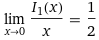

Source: https://www.mathworks.com/help/matlab/ref/besseli.html
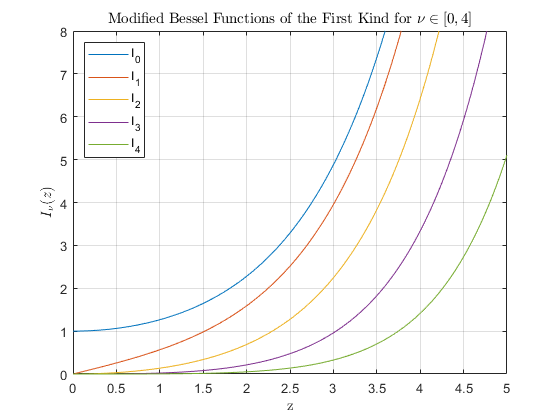

Misra, D.K. (2006). Appendix C: Bessel Functions. In Practical Electromagnetics, D.K. Misra (Ed.). https://doi-org.proxy2.library.illinois.edu/10.1002/9780470054208.app3

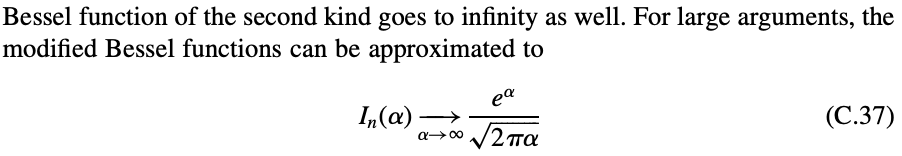


Zeros of Bessel’s Functions of the First Kind   

| # of Zeros |    J0(x) 	| J1(x)    	| J2(x)    	| J3(x)    	| J4(x)    	| J5(x)    	|
|-------------	|-----------------	|----------	|----------	|----------	|----------	|----------	|
|           1 	| 2.40483         	| 3.83171  	| 5.13562  	| 6.38016  	| 7.58834  	| 8.77148  	|
| 2           	| 5.52008         	| 7.01559  	| 8.41724  	| 9.76102  	| 11.06471 	| 12.3386  	|
| 3           	| 8.65373         	| 10.17347 	| 11.61984 	| 13.0152  	| 14.37254 	| 15.70017 	|
| 4           	| 11.79153        	| 13.32369 	| 14.79595 	| 16.22347 	| 17.61597 	| 18.98013 	|
| 5           	| 14.93092        	| 16.47063 	| 17.95982 	| 19.40941 	| 20.82693 	| 22.2178  	|

TABLE C.2 Zeros of the Derivatives of Bessel’s Functions of the First Kind

| Number of Zeros 	| J0'(x)   	| J1'(x)   	| J2'(x)   	| J3'(x)   	| J4'(x)   	| J5'(x)   	|
|-----------------	|----------	|----------	|----------	|----------	|----------	|----------	|
| 1               	| 3.83171  	| 1.84118  	| 3.05424  	| 4.20119  	| 5.31755  	| 6.41562  	|
| 2               	| 7.01559  	| 5.33144  	| 6.70613  	| 8.01524  	| 9.2824   	| 10.51986 	|
| 3               	| 10.17347 	| 8.53632  	| 9.96947  	| 11.34592 	| 12.68191 	| 13.98719 	|
| 4               	| 13.32369 	| 11.706   	| 13.17037 	| 14.58585 	| 15.96411 	| 17.31284 	|
| 5               	| 16.4706  	| 14.86359 	| 16.34752 	| 17.78875 	| 19.19603 	| 20.57551 	|

## https://functions.wolfram.com/Bessel-TypeFunctions/BesselI/introductions/Bessels/ShowAll.html

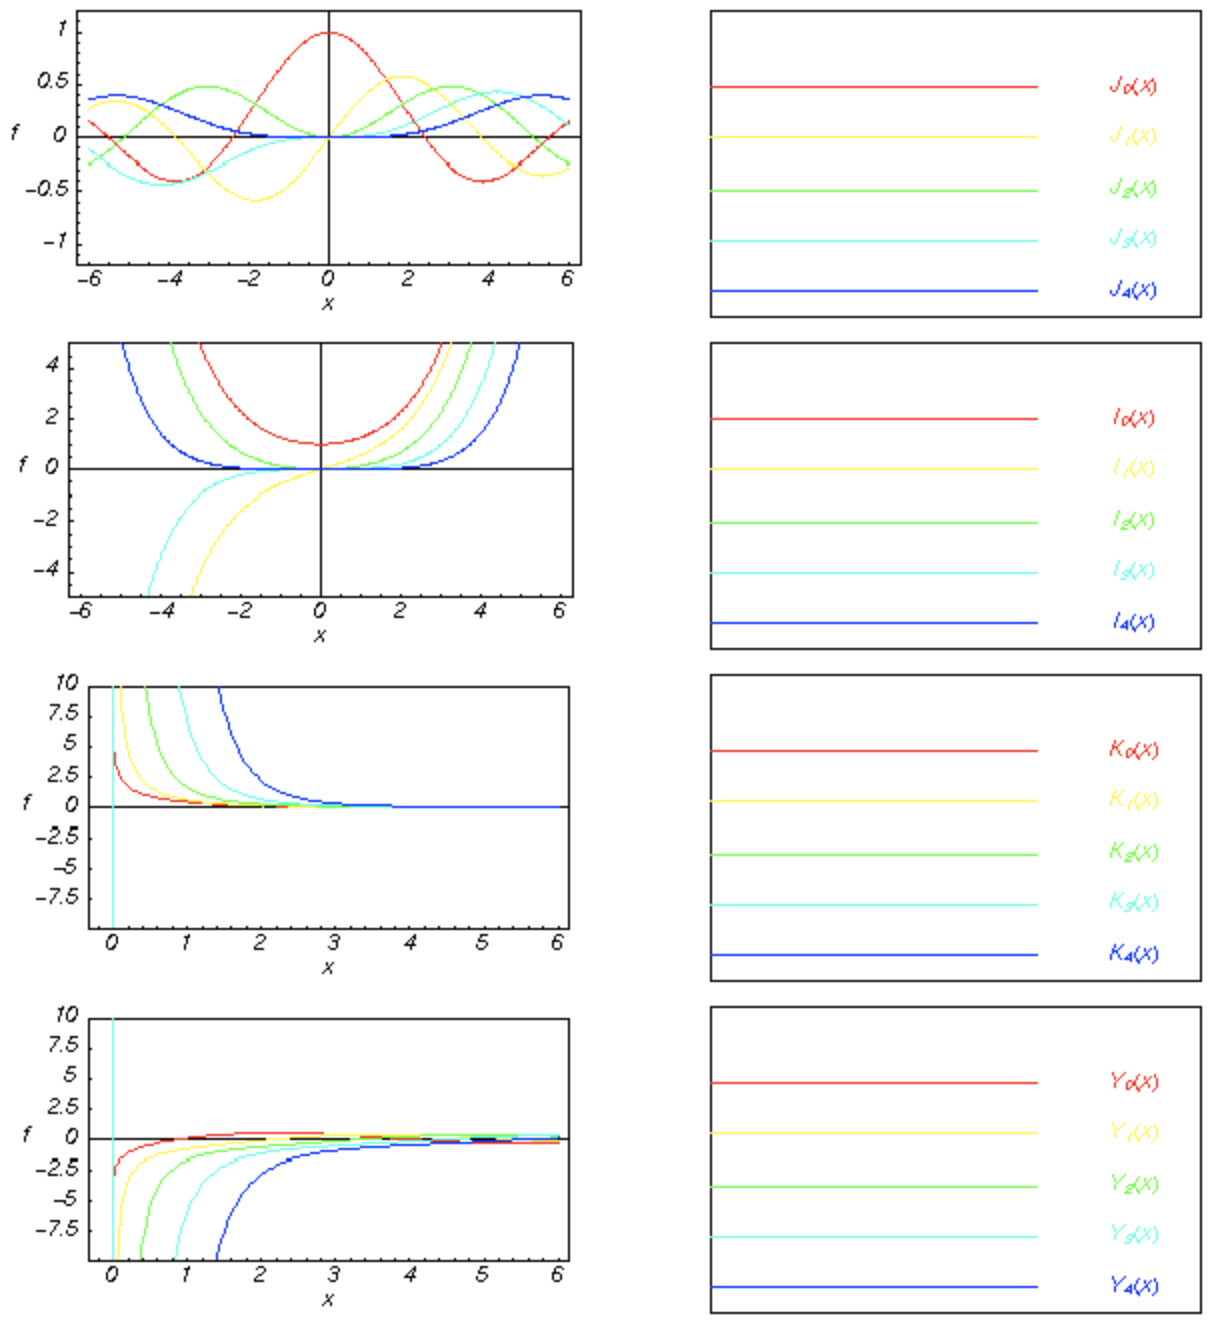

## Source: http://www.mhtlab.uwaterloo.ca/courses/me755/web_chap4.pdf

## Definitions .....................................................................

### 1. Bessel Equation

The second order differential equation given as

$x^2 \frac{d^2y}{dx^2} + x \frac{dy}{dx} + (x^2 - ν^2 )y=0$

is known as Bessel’s equation. Where the solution to Bessel’s equation yields Bessel functions of the first and second kind as follows:

$y=A J_ν(x)+B Y_ν(x)$

where $A$ and $B$ are arbitrary constants. While Bessel functions are often presented in text books and tables in the form of integer order, i.e. $ν=0, 1 , 2 ,...$, in fact they are defined for all real values of $−∞<ν<∞$.

### 2. Bessel Functions

a) First Kind: $Jν(x)$ in the solution to Bessel’s equation is referred to as a Bessel function of the first kind.

b) Second Kind: $Yν(x)$ in the solution to Bessel’s equation is referred to as a
Bessel function of the second kind or sometimes the Weber function or the
Neumann function.

b) Third Kind: The Hankel function or Bessel function of the third kind can be
written as


$Hν(1)(x)=Jν(x)+iYν(x), x> 0$  
$Hν(2)(x)=Jν(x)−iYν(x), x> 0$  


Because of the linear independence of the Bessel function of the first and second kind, the Hankel functions provide an alternative pair of solutions to the Bessel differential equation.

### 3. Modified Bessel Equation

By letting $x= ix$ (where $i=\sqrt{-1}$) in the Bessel equation we can obtain the modified Bessel equation of order ν, given as

$x^2 \frac{d^2y}{dx^2} + x \frac{dy}{dx}- (x^2 +ν^2 )y=0$


The solution to the modified Bessel equation yields modified Bessel functions of the first and second kind as follows:

$y=CIν(x)+DKν(x), x> 0$  

### 4. Modified Bessel Functions

a) First Kind: $Iν(x)$ in the solution to the modified Bessel’s equation is referred to as a modified Bessel function of the first kind.  

b) Second Kind: $Kν(x)$ in the solution to the modified Bessel’s equation is re-
ferred to as a modified Bessel function of the second kind or sometimes the
Weberfunction or the Neumann function.  


$I_0(x)=J_0(i \cdot x)$  
$I_1(x)=-i\cdot J_1(i \cdot x)$  
$I_2(x)=- J_2(i \cdot x)$  
$I_\nu(x)=i^{-\nu} \cdot J_\nu(i \cdot x)=J_\nu(i^{3/2} \cdot x)$   


## Derivative (Recurrence) Formulas of Bessel Functions

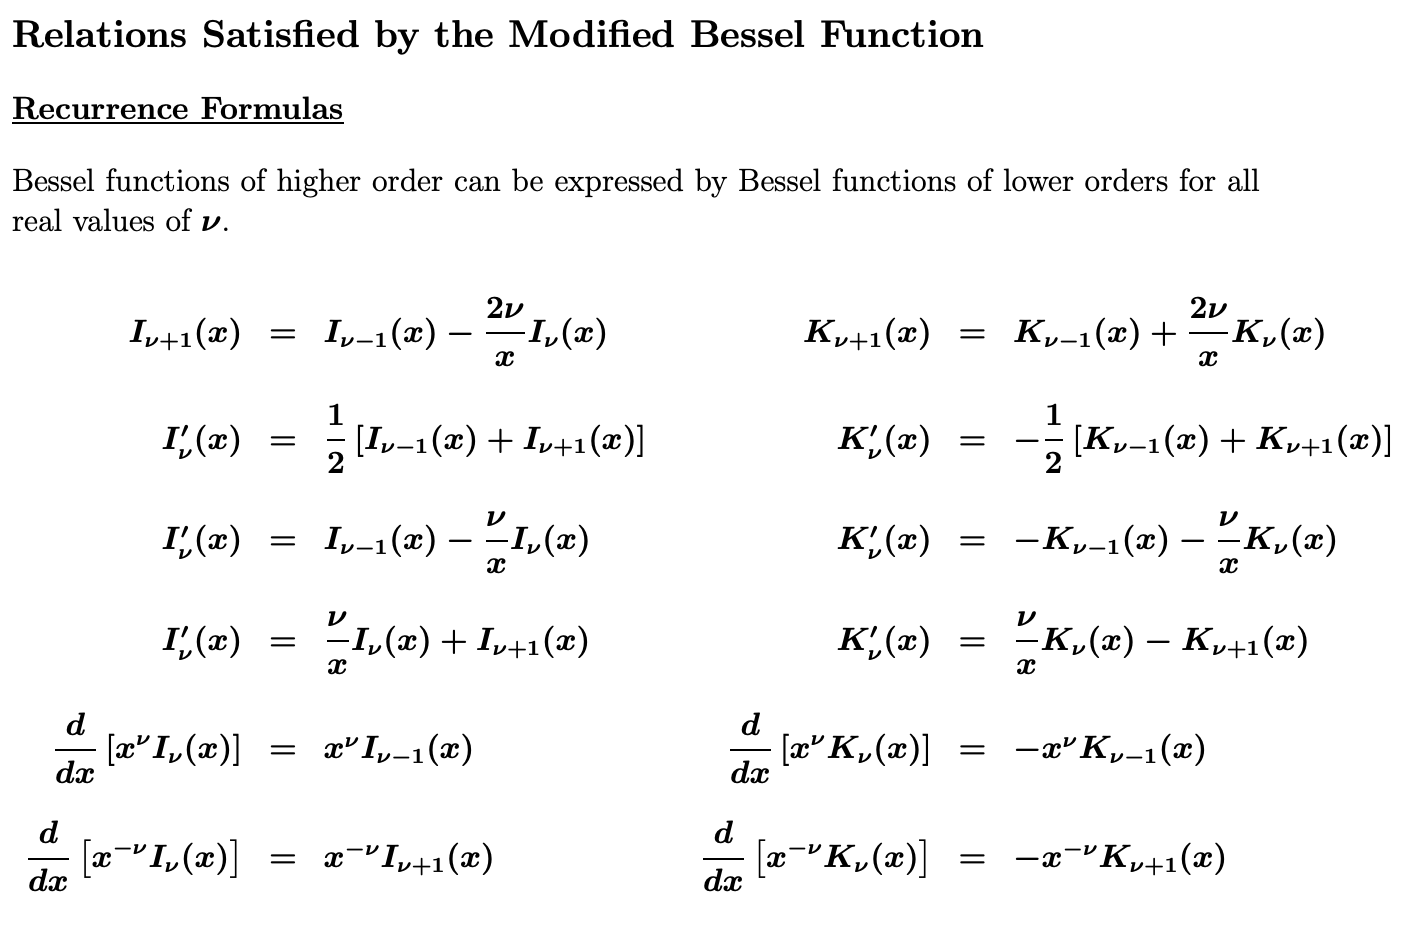

## Integral Definitions of Bessel functions
For integer orders $n=0,1,2,3...$
\begin{align}
I_n(x)&=\frac{1}{\pi} \int_0^\pi \cos{(n\theta)} \,\exp(x\cos{\theta})\, \mathrm{d}\theta  \\
I_0(x)&=\frac{1}{\pi} \int_0^\pi \exp(x\cos{\theta})\, \mathrm{d}\theta \\
I_1(x)&=\frac{1}{\pi} \int_0^\pi \cos{(\theta)} \, \exp(x\cos{\theta})\, \mathrm{d}\theta \\ 
I_0(x)&=\frac{1}{\pi} \int_0^\pi \cosh(x\cos{\theta})\, \mathrm{d}\theta \\
I_1(x)&= \dfrac{\mathrm{d}I_0(x)}{\mathrm{d}x}=\frac{1}{\pi} \int_0^\pi \cosh(x\cos{\theta})\, \mathrm{d}\theta \\
\end{align}

# Hyperbolic Trig Definitions
Source: https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions on 2021_07_13

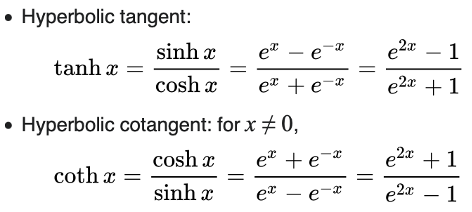